# Cleaning Data

In [191]:
import time
#from selenium import webdriver
from bs4 import BeautifulSoup
#from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import requests
import re
import os
from lxml import etree
import lxml.html, lxml.html.clean
from urllib.parse import urlparse
from urllib.parse import parse_qs
import pandas as pd
from itertools import product
import time
import regex
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud



#driver = webdriver.Chrome(ChromeDriverManager().install())
verbose_flag = True
# htmlSource = driver.page_source

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ryeoh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ryeoh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ryeoh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Load data


In [192]:
path_data_scientist = r".\data_scientist_2022_03_03.ftr"
path_data_engineer =r".\data_engineer_2022_03_03.ftr"
path_data_analyst = r".\data_analyst_2022_03_03.ftr"


files = [path_data_scientist, path_data_engineer, path_data_analyst]

In [193]:
df_data_careers = None

start = True
for file_path in files:
    df_read = pd.read_feather(file_path)

    if(start):
        df_data_careers = df_read.copy()
        start = False

    else:
        df_data_careers = pd.concat([df_data_careers, df_read])

df_data_careers.reset_index(drop=True, inplace=True)
        


### Start cleaning data

#### Format ID

In [194]:
# Format job id to be numerical
df_data_careers['job_id'] = df_data_careers.job_id.astype('str').str.extract("(\d+)")

In [195]:
df_data_careers.job_id.nunique()

7851

In [196]:
df_data_careers['job_title'] = df_data_careers['job_title'].str.lower()

#### Drop non-unique jobs

In [197]:
df_data_careers.drop_duplicates(keep='first', subset=['job_id'], inplace=True)

#### Format salary range

In [198]:
#replace wrong values with nan
df_data_careers.loc[df_data_careers['salary_range'].str.contains('Posted'), 'salary_range'] = np.nan

In [199]:
#clean MYR
df_malaysian_salary = df_data_careers.loc[~df_data_careers['salary_range'].isnull() & df_data_careers['salary_range'].str.contains('MYR'), :]


In [200]:
df_malaysian_salary.head()

,job_id,job_title,salary_range,job_description,job_level,experience,job_type,qualifications,job_specialization,company_name,company_registration,company_size,company_industry,job_link,search_term,state
2,4832121,sql database administrator (数据库管理员),"MYR 15,000 - MYR 25,000","Job DescriptionJob Requirements: Must speak, r...",Senior Executive,3 years,Full-Time,"Bachelor's Degree, Post Graduate Diploma, Prof...","Computer/Information Technology, IT-Network/Sy...",Morivy Data and Technology Inc.,None,1 - 50 Employees,Computer / Information Technology (Software),/en/job/sql-database-administrator-%E6%95%B0%E...,data scientist,negeri-sembilan
3,4839272,software engineer,"MYR 3,000 - MYR 4,200",Job Description QualificationDegree or higher ...,Junior Executive,2 years,Full-Time,Not Specified,"Computer/Information Technology, IT-Software",TAIACE ENERGY SDN BHD,1006041-X,1 - 50 Employees,Environment/Health/Safety,/en/job/software-engineer-4839272?jobId=jobstr...,data scientist,negeri-sembilan
4,4852008,manufacturing engineer- fresh graduates (1 yea...,"MYR 3,000 - MYR 3,500",Job HighlightsCareer AdvancementDaily Meal All...,Entry Level,None,Full-Time,"Bachelor's Degree, Post Graduate Diploma, Prof...","Engineering, Electrical, Mechanical",Plexus Manufacturing Sdn Bhd,399136-M,More than 5000 Employees,Electrical & Electronics,/en/job/manufacturing-engineer-fresh-graduates...,data scientist,negeri-sembilan
7,4819995,system support executive,"MYR 1,500 - MYR 2,000",Job DescriptionSystem Support ExecutiveDeliver...,Junior Executive,2 years,Full-Time,Not Specified,"Computer/Information Technology, IT-Software",Infomax Supplies,001423432-A,1 - 50 Employees,Computer/Information Technology (Hardware),/en/job/system-support-executive-4819995?jobId...,data scientist,negeri-sembilan
8,4831057,junior chemist product development laboratory,"MYR 2,500 - MYR 3,300",Job Highlights5-day weekProgressive working en...,Junior Executive,2 years,Full-Time,"Professional Certificate, Diploma, Advanced/Hi...","Sciences, Chemistry",MAPEI MALAYSIA SDN BHD,231780-K,51 - 200 Employees,Manufacturing / Production,/en/job/junior-chemist-product-development-lab...,data scientist,negeri-sembilan


In [201]:
extracted_salary = df_malaysian_salary['salary_range'].str.findall("(\d+,\d+)")

In [202]:
df_malaysian_salary.loc[:,'start_salary_range'] = extracted_salary.str[0]
df_malaysian_salary.loc[:,'end_salary_range'] = extracted_salary.str[1]

C:\Users\ryeoh\Anaconda3\envs\forwardSchool\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [203]:
df_malaysian_salary['start_salary_range'] = df_malaysian_salary['start_salary_range'].str.replace(',','')
df_malaysian_salary.loc[:,'end_salary_range'] = df_malaysian_salary.loc[:,'end_salary_range'].str.replace(',','')

C:\Users\ryeoh\AppData\Local\Temp/ipykernel_10220/2981404410.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_malaysian_salary['start_salary_range'] = df_malaysian_salary['start_salary_range'].str.replace(',','')
C:\Users\ryeoh\Anaconda3\envs\forwardSchool\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [204]:
df_malaysian_salary['start_salary_range'] = df_malaysian_salary['start_salary_range'].astype(float)
df_malaysian_salary['end_salary_range'] = df_malaysian_salary['end_salary_range'].astype(float)

C:\Users\ryeoh\AppData\Local\Temp/ipykernel_10220/445547010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_malaysian_salary['start_salary_range'] = df_malaysian_salary['start_salary_range'].astype(float)
C:\Users\ryeoh\AppData\Local\Temp/ipykernel_10220/445547010.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_malaysian_salary['end_salary_range'] = df_malaysian_salary['end_salary_range'].astype(float)


In [205]:
df_malaysian_salary.shape

(1565, 18)

In [206]:
currencies = df_data_careers['salary_range'].str[:3]

In [207]:
currencies.value_counts()

MYR    1565
SGD       3
HKD       1
Name: salary_range, dtype: int64

In [208]:
#clean SGD
df_singaporean_salary = df_data_careers.loc[~df_data_careers['salary_range'].isnull() & df_data_careers['salary_range'].str.contains('SGD'), :]
extracted_salary_SGD = df_singaporean_salary['salary_range'].str.findall("(\d+,\d+)")
df_singaporean_salary.loc[:,'start_salary_range'] = extracted_salary_SGD.str[0]
df_singaporean_salary.loc[:,'end_salary_range'] = extracted_salary_SGD.str[1]
df_singaporean_salary['start_salary_range'] = df_singaporean_salary['start_salary_range'].str.replace(',','')
df_singaporean_salary.loc[:,'end_salary_range'] = df_singaporean_salary.loc[:,'end_salary_range'].str.replace(',','')

#conversion to MYR
MYR = 3.08
df_singaporean_salary['start_salary_range'] = df_singaporean_salary['start_salary_range'].astype(float)*3.08
df_singaporean_salary['end_salary_range'] = df_singaporean_salary['end_salary_range'].astype(float)*3.08

df_singaporean_salary

C:\Users\ryeoh\AppData\Local\Temp/ipykernel_10220/2162059839.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_singaporean_salary['start_salary_range'] = df_singaporean_salary['start_salary_range'].str.replace(',','')
C:\Users\ryeoh\AppData\Local\Temp/ipykernel_10220/2162059839.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_singaporean_salary['start_salary_range'] = df_singaporean_salary['start_salary_range'].astype(float)*3.08
C:\Users\ryeoh\AppData\Local\Temp/ipykernel_10220/2162059839.py:12

,job_id,job_title,salary_range,job_description,job_level,experience,job_type,qualifications,job_specialization,company_name,company_registration,company_size,company_industry,job_link,search_term,state,start_salary_range,end_salary_range
0,4839088,big data lead (work in singapore) - 44565,"SGD 7,000 - SGD 10,500",Job HighlightsExciting future with breakthroug...,Manager,7 years,Full-Time,"Bachelor's Degree, Post Graduate Diploma, Prof...","Computer/Information Technology, IT-Software",Keysight Technologies Malaysia Sdn. Bhd.,463532-M,2001 - 5000 Employees,Electrical & Electronics,/en/job/big-data-lead-work-in-singapore-44565-...,data scientist,negeri-sembilan,21560.0,32340.0
6595,9299289,"senior commodity specialist (based in penang, ...","SGD 2,000 - SGD 3,000",Job DescriptionResponsibilities:Manages the ou...,Junior Executive,None,Full-Time,"Bachelor's Degree, Post Graduate Diploma, Prof...","Manufacturing, Purchasing/Material Mgmt",ASM Front-End Manufacturing Singapore Pte Ltd,200310868G,201 - 500 Employees,Semiconductor/Wafer Fabrication,/en/job/senior-commodity-specialist-based-in-p...,data analyst,penang,6160.0,9240.0
6713,9299313,"senior buyer (penang, malaysia)","SGD 2,000 - SGD 3,000",Job DescriptionResponsibilities:Responsible fo...,Junior Executive,None,Full-Time,"Bachelor's Degree, Post Graduate Diploma, Prof...","Manufacturing, Purchasing/Material Mgmt",ASM Front-End Manufacturing Singapore Pte Ltd,200310868G,201 - 500 Employees,Semiconductor/Wafer Fabrication,/en/job/senior-buyer-penang-malaysia-9299313/o...,data analyst,penang,6160.0,9240.0


In [209]:
#clean HKD
df_hongkong_salary = df_data_careers.loc[~df_data_careers['salary_range'].isnull() & df_data_careers['salary_range'].str.contains('HKD'), :]
extracted_salary_HKD = df_hongkong_salary['salary_range'].str.findall("(\d+,\d+)")
df_hongkong_salary.loc[:,'start_salary_range'] = extracted_salary_HKD.str[0]
df_hongkong_salary.loc[:,'end_salary_range'] = extracted_salary_HKD.str[1]
df_hongkong_salary['start_salary_range'] = df_hongkong_salary['start_salary_range'].str.replace(',','')
df_hongkong_salary.loc[:,'end_salary_range'] = df_hongkong_salary.loc[:,'end_salary_range'].str.replace(',','')

#conversion to MYR
MYR = 0.54
df_hongkong_salary['start_salary_range'] = df_hongkong_salary['start_salary_range'].astype(float)*MYR
df_hongkong_salary['end_salary_range'] = df_hongkong_salary['end_salary_range'].astype(float)*MYR

df_hongkong_salary

C:\Users\ryeoh\Anaconda3\envs\forwardSchool\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\ryeoh\AppData\Local\Temp/ipykernel_10220/3422634028.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hongkong_salary['start_salary_range'] = df_hongkong_salary['start_salary_range'].str.replace(',','')
C:\Users\ryeoh\Anaconda3\envs\forwardSchool\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying 

,job_id,job_title,salary_range,job_description,job_level,experience,job_type,qualifications,job_specialization,company_name,company_registration,company_size,company_industry,job_link,search_term,state,start_salary_range,end_salary_range
3908,4845280,system analyst / senior analyst programmer (ba...,"HKD 25,000 - HKD 35,000",Job DescriptionAbout this roleRegional support...,Senior Executive,5 years,Full-Time,Not Specified,"Computer/Information Technology, IT-Software",Nexperia Malaysia Sdn.Bhd.,244835-W,2001 - 5000 Employees,Semiconductor/Wafer Fabrication,/en/job/system-analyst-senior-analyst-programm...,data analyst,selangor,13500.0,18900.0


In [210]:
df_data_careers['start_salary_range'] = np.nan
df_data_careers['end_salary_range'] = np.nan

In [211]:
def update_data(main_df:pd.DataFrame, new_df:pd.DataFrame, column_names:list):
    for column_name in column_names:
        main_df.loc[new_df.index, column_name] = new_df[column_name]
    
    return main_df

In [212]:
new_data_dfs = [df_malaysian_salary, df_singaporean_salary, df_hongkong_salary]

for df in new_data_dfs:
    df_data_careers = update_data(df_data_careers, df, ['start_salary_range', 'end_salary_range'])


In [213]:
df_data_careers.drop('salary_range', axis=1, inplace=True)

#### Clean experience

In [214]:
df_clean_experience = df_data_careers.copy()
df_clean_experience['experience'] = df_data_careers['experience'].str.replace('years', '')
df_clean_experience['experience'] = df_clean_experience['experience'].str.replace('year', '')

df_clean_experience['experience'] = df_clean_experience['experience'].str.strip()
df_clean_experience.loc[df_clean_experience[df_clean_experience['experience'].isnull()].index, 'experience'] = '0'
df_clean_experience['experience'] = df_clean_experience['experience'].astype(int)
df_clean_experience.head(10)

df_data_careers = df_clean_experience.copy()

#### Filter relevant jobs

In [215]:
df_filtered_data = []

In [216]:
df_data_careers.shape

(7851, 17)

Get all jobs mentioning data

In [217]:
df_data_only = df_data_careers[df_data_careers.job_title.str.contains('data')].copy()
df_data_only.shape

(571, 17)

In [218]:
df_filtered_data.append(df_data_only)

In [219]:
df_no_data = df_data_careers.drop(df_data_only.index)

Get all jobs mentioning computer science

In [220]:
df_computer_science = df_no_data[df_no_data['job_title'].str.contains('science|scientist') & df_no_data['job_title'].str.contains('computer')].copy()

In [221]:
df_filtered_data.append(df_computer_science)

In [222]:
df_no_computer_science = df_no_data.drop(df_computer_science.index)

Get all jobs mentioning machine learning

In [223]:
df_machine_learning = df_no_computer_science[df_no_computer_science['job_title'].str.contains('machine learning')].copy()

In [224]:
df_filtered_data.append(df_machine_learning)

In [225]:
df_no_machine_learning = df_no_computer_science.drop(df_machine_learning.index)

Get all software jobs mentioning analytics, machine learning, artificial intelligence in description

In [226]:
df_software_analytics = df_no_machine_learning[df_no_machine_learning['job_title'].str.contains('software') & df_no_machine_learning['job_description'].str.contains('artificial|intelligence|analytics|machine learning')]

In [227]:
df_filtered_data.append(df_software_analytics)

In [228]:
df_no_software_analytics = df_no_machine_learning.drop(df_software_analytics.index)

Get all jobs mentioning artificial intelligence and machine learning

In [229]:
df_misc = df_no_software_analytics[df_no_software_analytics['job_description'].str.contains('machine learning|artificial intelligence|data science|data engineering')]
df_ai = df_misc[df_misc['job_title'].str.contains(r'\ba\W*i\b', regex=True)]

In [230]:
df_filtered_data.append(df_ai)

In [231]:
df_misc_no_ai = df_misc.drop(df_ai.index)
df_misc_no_ai.shape


(219, 17)

In [232]:
df_intelligence = df_misc_no_ai[df_misc_no_ai['job_title'].str.contains('ml ops|mlops|analytics|smart|application scientist|chief|analytics|business intelligence|architect|analytics|intelligent|automation',regex=True)]

In [233]:
df_filtered_data.append(df_intelligence)

### Join back all filtered DF

In [234]:
df_all_data_jobs_cleaned = None
start = True

for df in df_filtered_data:
    if(start):
        df_all_data_jobs_cleaned = df.copy()
        start = False

    else:
        df_all_data_jobs_cleaned = pd.concat([df_all_data_jobs_cleaned, df])

df_all_data_jobs_cleaned.shape


(689, 17)

In [235]:
df_dropped = df_data_careers.drop(df_all_data_jobs_cleaned.index)

In [236]:
df_business_intelligence = df_dropped[df_dropped['job_title'].str.contains(r'business intelligence|analytics|intelligence|power bi|\bb\W*i\b')]

In [237]:
df_all_data_jobs_cleaned = pd.concat([df_all_data_jobs_cleaned, df_business_intelligence])

In [238]:
stragglers = df_dropped[df_dropped['job_title'].str.contains(r'artificial intelligence|\ba\W*i\b|mlops|data engineering|data engineer')]

In [239]:
df_all_data_jobs_cleaned = pd.concat([df_all_data_jobs_cleaned, stragglers])

In [240]:
df_dropped = df_dropped.drop(stragglers.index)

### EDA for data related jobs

In [241]:
sns.set_palette(sns.color_palette('RdYlBu'))

In [242]:
df_data_jobs = df_all_data_jobs_cleaned.drop_duplicates('job_id')


In [243]:
df_data_jobs[~df_data_jobs['start_salary_range'].isna()].shape

(115, 17)

In [244]:
df_data_jobs['job_id'].nunique()

801

In [245]:
len(df_data_jobs)

801

In [246]:
df_data_jobs.head(1)

,job_id,job_title,job_description,job_level,experience,job_type,qualifications,job_specialization,company_name,company_registration,company_size,company_industry,job_link,search_term,state,start_salary_range,end_salary_range
0,4839088,big data lead (work in singapore) - 44565,Job HighlightsExciting future with breakthroug...,Manager,7,Full-Time,"Bachelor's Degree, Post Graduate Diploma, Prof...","Computer/Information Technology, IT-Software",Keysight Technologies Malaysia Sdn. Bhd.,463532-M,2001 - 5000 Employees,Electrical & Electronics,/en/job/big-data-lead-work-in-singapore-44565-...,data scientist,negeri-sembilan,21560.0,32340.0


### How many jobs in each state are there?

In [247]:
df_jobs_by_state = df_data_jobs.groupby('state').size().sort_values()
df_jobs_by_state


state
perak                2
perlis               2
sabah                2
pahang               3
negeri-sembilan      6
kedah                7
melaka               7
sarawak              9
johor               16
penang              65
selangor           267
kuala-lumpur       415
dtype: int64

C:\Users\ryeoh\Anaconda3\envs\forwardSchool\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


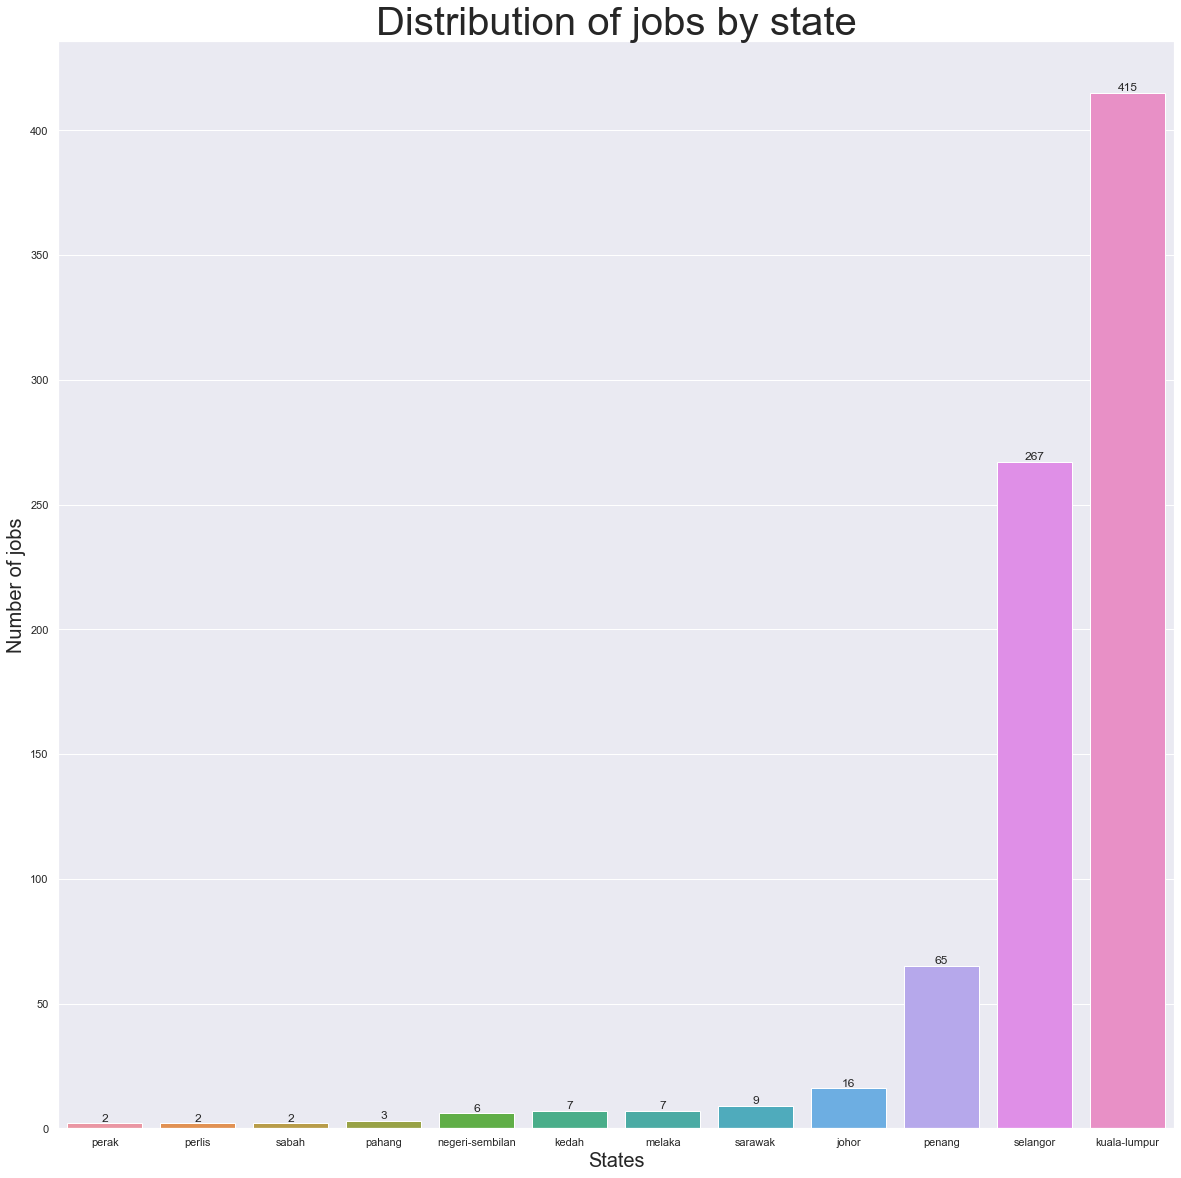

In [248]:
sns.set(rc={'figure.figsize':(20,20)})
sns.set_palette('Reds')
bar = sns.barplot(df_jobs_by_state.index, df_jobs_by_state.values)
bar.set_title("Distribution of jobs by state", fontsize=40)
bar.set_ylabel("Number of jobs", fontsize=20)
bar.set_xlabel("States", fontsize=20)
bar.bar_label(bar.containers[0])
plt.show()

In [249]:
df_jobs_by_industry = df_data_jobs.groupby('company_industry').size().sort_values()
df_jobs_by_industry

company_industry
Tobacco                                                1
Sports                                                 1
Apparel                                                1
Polymer / Plastic / Rubber / Tyres                     1
Law / Legal                                            1
Science & Technology                                   2
Arts / Design / Fashion                                2
Non-Profit Organisation / Social Services / NGO        2
Hotel / Hospitality                                    2
Accounting / Audit / Tax Services                      3
General & Wholesale Trading                            3
Entertainment / Media                                  3
Construction / Building / Engineering                  3
Government / Defence                                   3
Travel / Tourism                                       3
Chemical/Fertilizers/Pesticides                        3
Agricultural / Plantation / Poultry / Fisheries        3
Aerospace / Av

### Which is the largest hiring industry?

C:\Users\ryeoh\Anaconda3\envs\forwardSchool\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '5'),
 Text(0, 0, '5'),
 Text(0, 0, '5'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '9'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '13'),
 Text(0, 0, '13'),
 Text(0, 0, '14'),
 Text(0, 0, '15'),
 Text(0, 0, '16'),
 Text(0, 0, '20'),
 Text(0, 0, '23'),
 Text(0, 0, '27'),
 Text(0, 0, '32'),
 Text(0, 0, '36'),
 Text(0, 0, '47'),
 Text(0, 0, '52'),
 Text(0, 0, '55'),
 Text(0, 0, '82'),
 Text(0, 0, '152')]

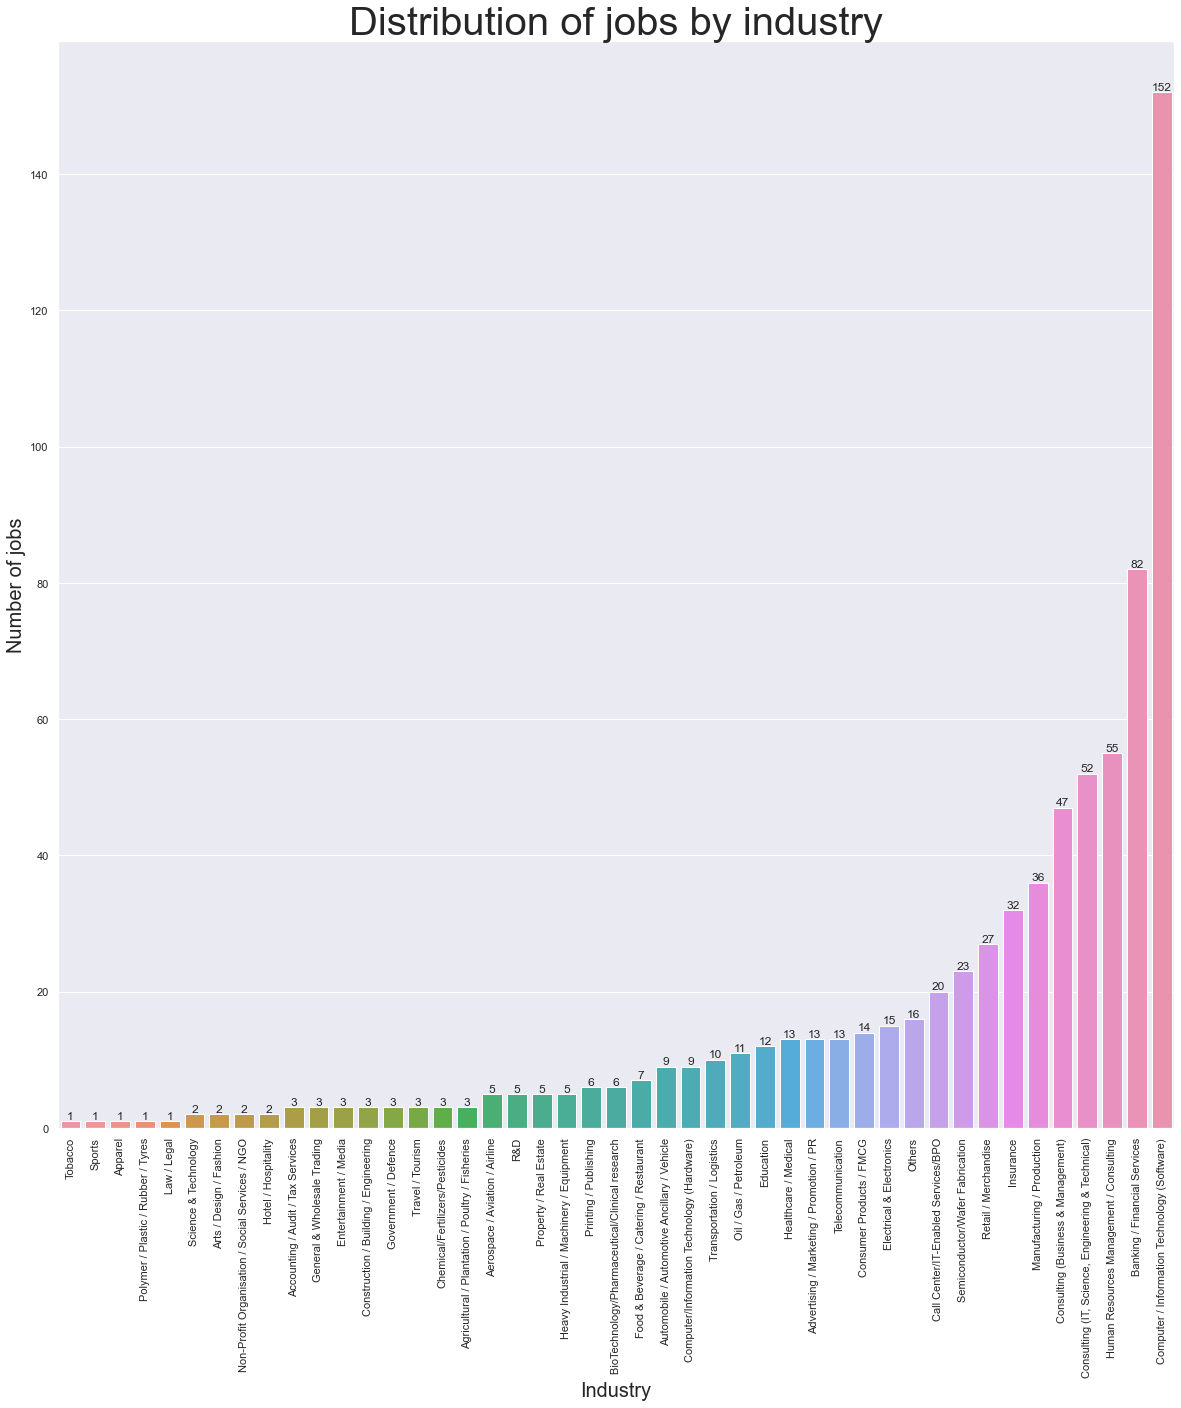

In [250]:
sns.set(rc={'figure.figsize':(20,20)})
bar = sns.barplot(df_jobs_by_industry.index, df_jobs_by_industry.values)
bar.set_title("Distribution of jobs by industry", fontsize=40)
bar.set_ylabel("Number of jobs", fontsize=20)
bar.set_xlabel("Industry", fontsize=20)
bar.tick_params(axis='x', rotation=90)
bar.bar_label(bar.containers[0])

In [251]:
df_data_jobs['median_salary'] = (df_data_jobs['start_salary_range'] + df_data_jobs['end_salary_range'])/2

C:\Users\ryeoh\AppData\Local\Temp/ipykernel_10220/3361309783.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_jobs['median_salary'] = (df_data_jobs['start_salary_range'] + df_data_jobs['end_salary_range'])/2


In [252]:
df_median_salary_by_state = df_data_jobs.groupby('state')['median_salary'].median()
df_median_salary_by_state

state
johor               5650.0
kedah               2900.0
kuala-lumpur        6250.0
melaka                 NaN
negeri-sembilan    20000.0
pahang                 NaN
penang              3400.0
perak                  NaN
perlis                 NaN
sabah                  NaN
sarawak             4200.0
selangor            5750.0
Name: median_salary, dtype: float64

### What are the median salaries by state?

[Text(0, 0, '20000'),
 Text(0, 0, '2900'),
 Text(0, 0, ''),
 Text(0, 0, '5750'),
 Text(0, 0, '5650'),
 Text(0, 0, '4200'),
 Text(0, 0, ''),
 Text(0, 0, '3400'),
 Text(0, 0, '6250'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '')]

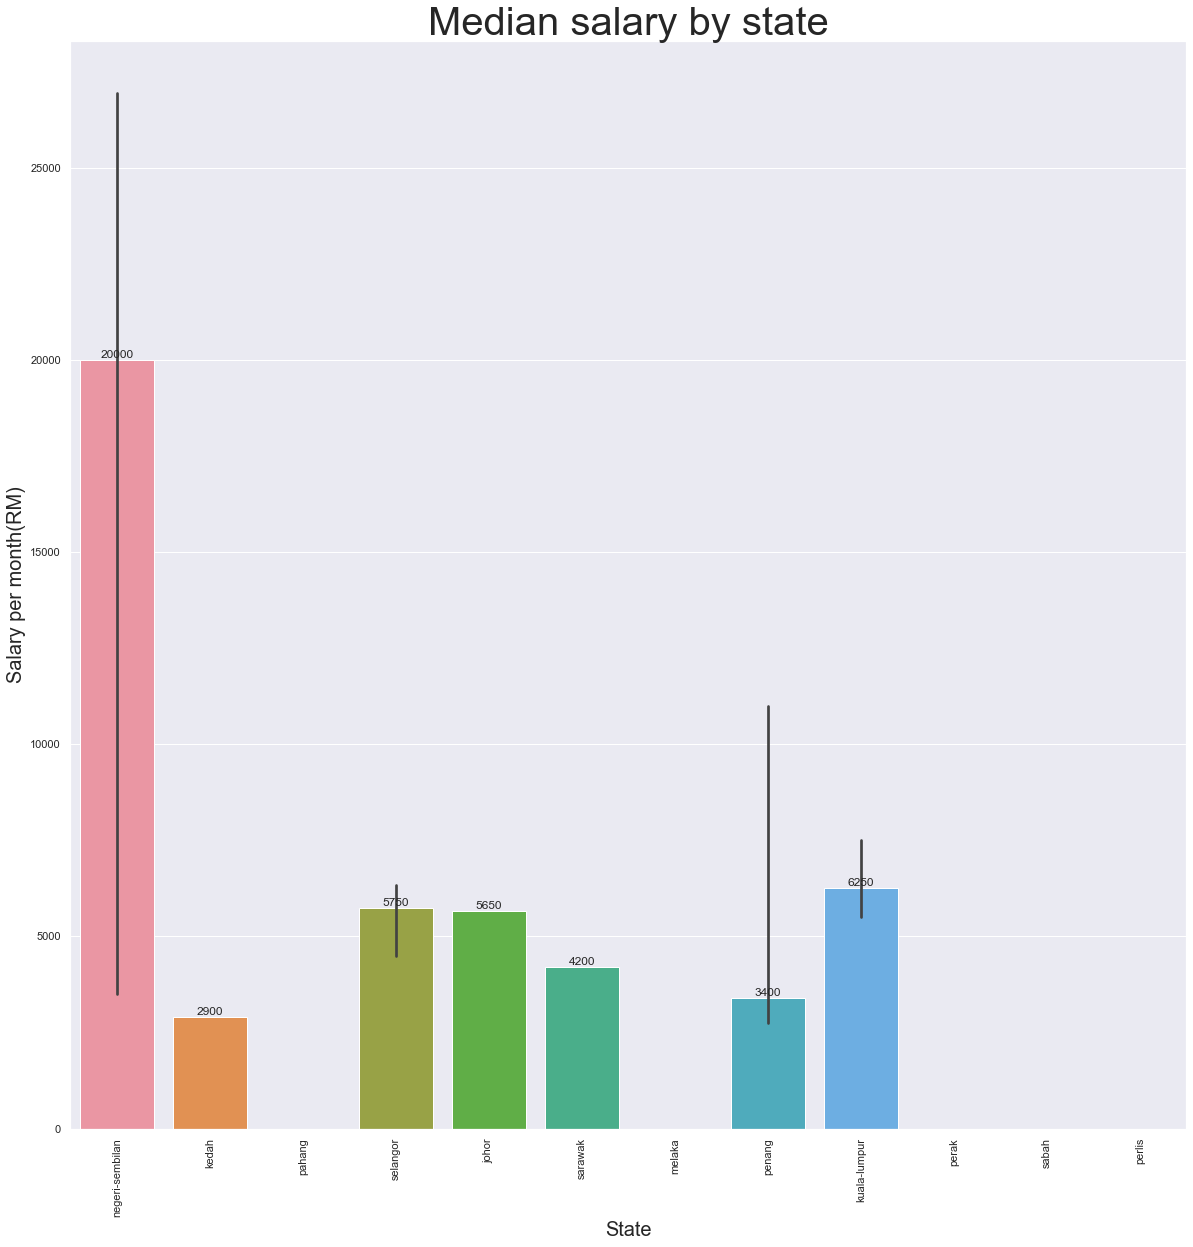

In [253]:
sns.set(rc={'figure.figsize':(20,20)})
bar = sns.barplot(data=df_data_jobs, x='state', y='median_salary', estimator=np.median)
bar.set_title("Median salary by state", fontsize=40)
bar.set_ylabel("Salary per month(RM)", fontsize=20)
bar.set_xlabel("State", fontsize=20)
bar.tick_params(axis='x', rotation=90)
bar.bar_label(bar.containers[0])

In [254]:
df_salary_by_state = df_data_jobs.groupby('state')['median_salary']

In [255]:
df_salary_by_state

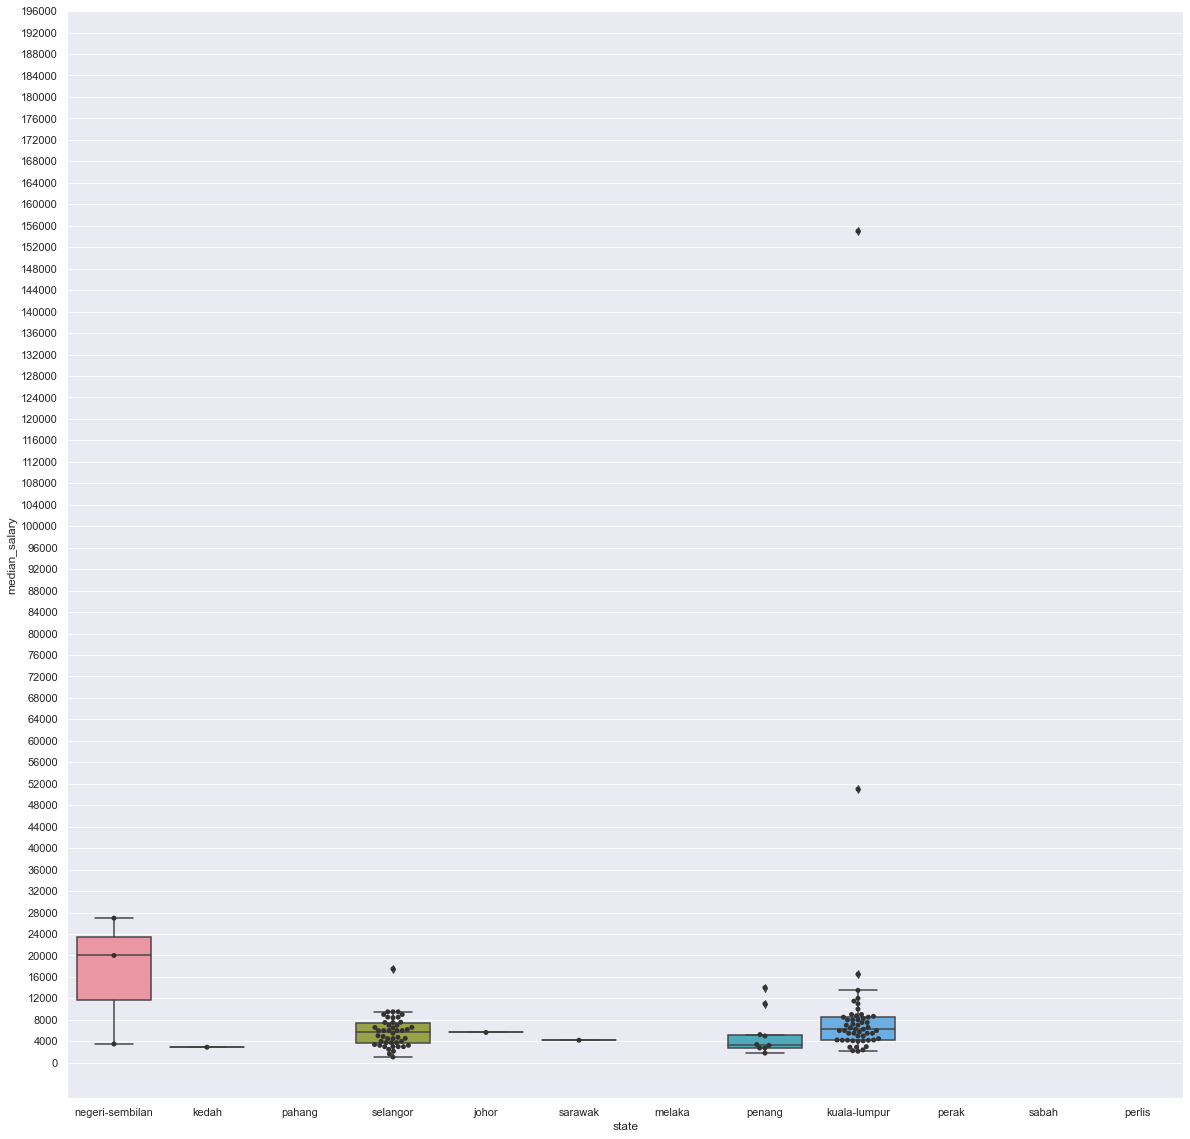

In [256]:
ax = sns.swarmplot(data=df_data_jobs, x="state", y="median_salary", color=".2")
ax = sns.boxplot(data=df_data_jobs, x="state", y="median_salary")
ax.set_yticks(range(0,200000,4000))

In [257]:
df_data_jobs[df_data_jobs['median_salary']>30000].iloc[1]['job_link']

'/en/job/senior-bi-analyst-4819647?jobId=jobstreet-my-job-4819647&sectionRank=213&token=0~a0bcc0d1-e1ff-45de-9c79-f95f50f48656&fr=SRP%20Job%20Listing'

In [258]:
df_no_outliers = df_data_jobs[df_data_jobs['median_salary']<30000]

[Text(0, 0, '16816.7'),
 Text(0, 0, '2900'),
 Text(0, 0, '5741.09'),
 Text(0, 0, '5650'),
 Text(0, 0, '4200'),
 Text(0, 0, '5466.67'),
 Text(0, 0, '6602')]

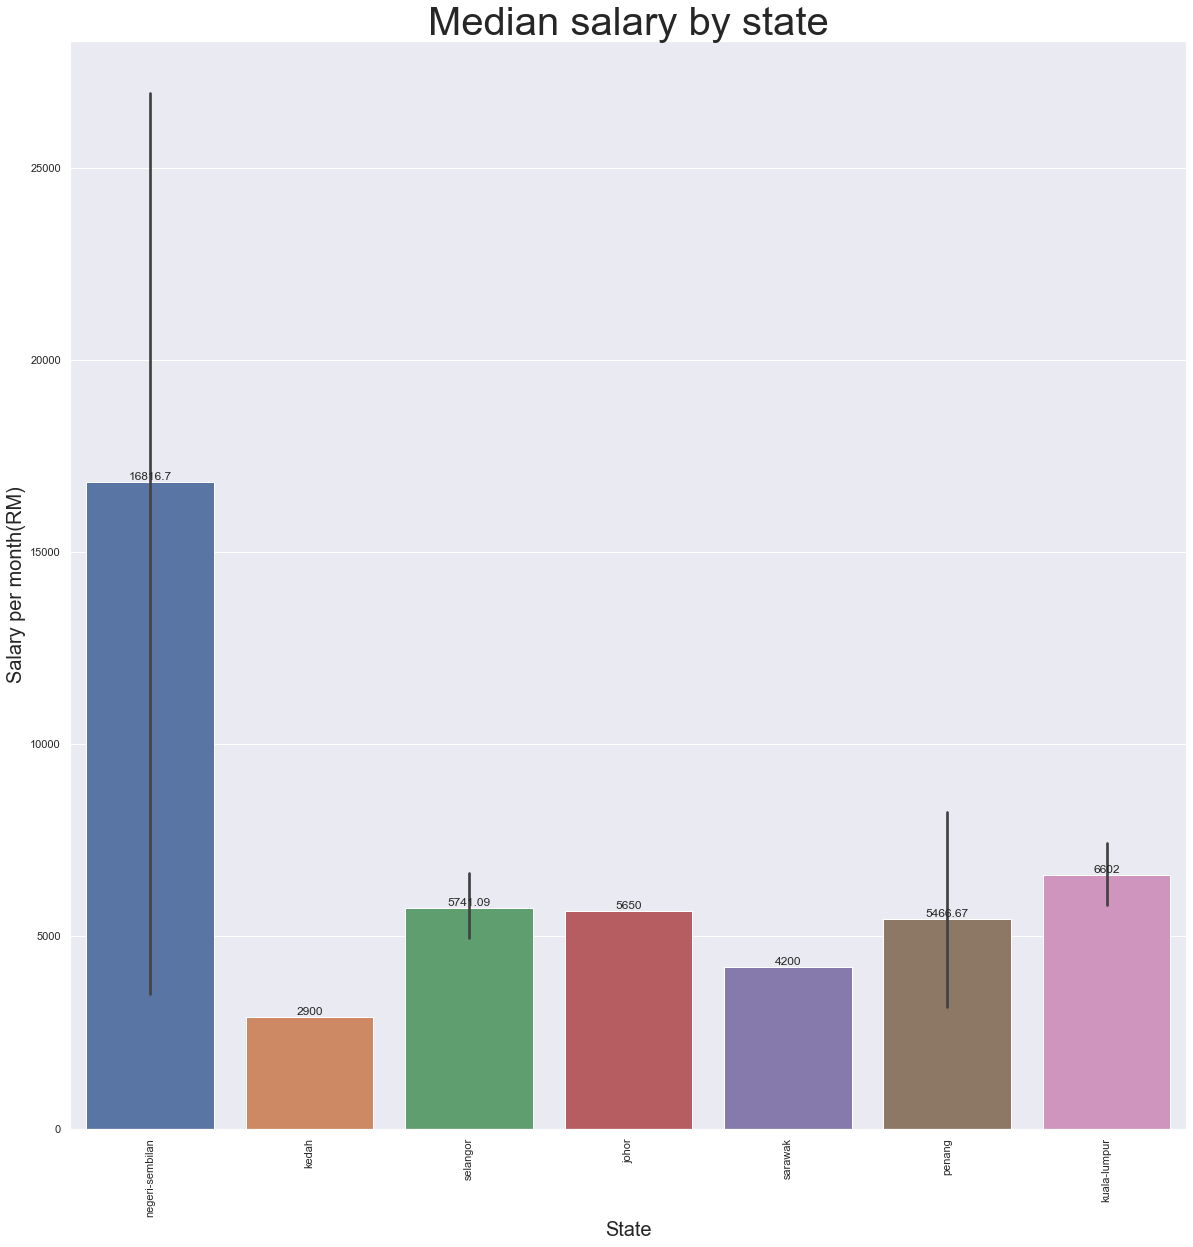

In [259]:
sns.set(rc={'figure.figsize':(20,20)})
bar = sns.barplot(data=df_no_outliers, x='state', y='median_salary')
bar.set_title("Median salary by state", fontsize=40)
bar.set_ylabel("Salary per month(RM)", fontsize=20)
bar.set_xlabel("State", fontsize=20)
bar.tick_params(axis='x', rotation=90)
bar.bar_label(bar.containers[0])

In [260]:
df_salary_by_company_size = df_no_outliers.groupby('company_size')

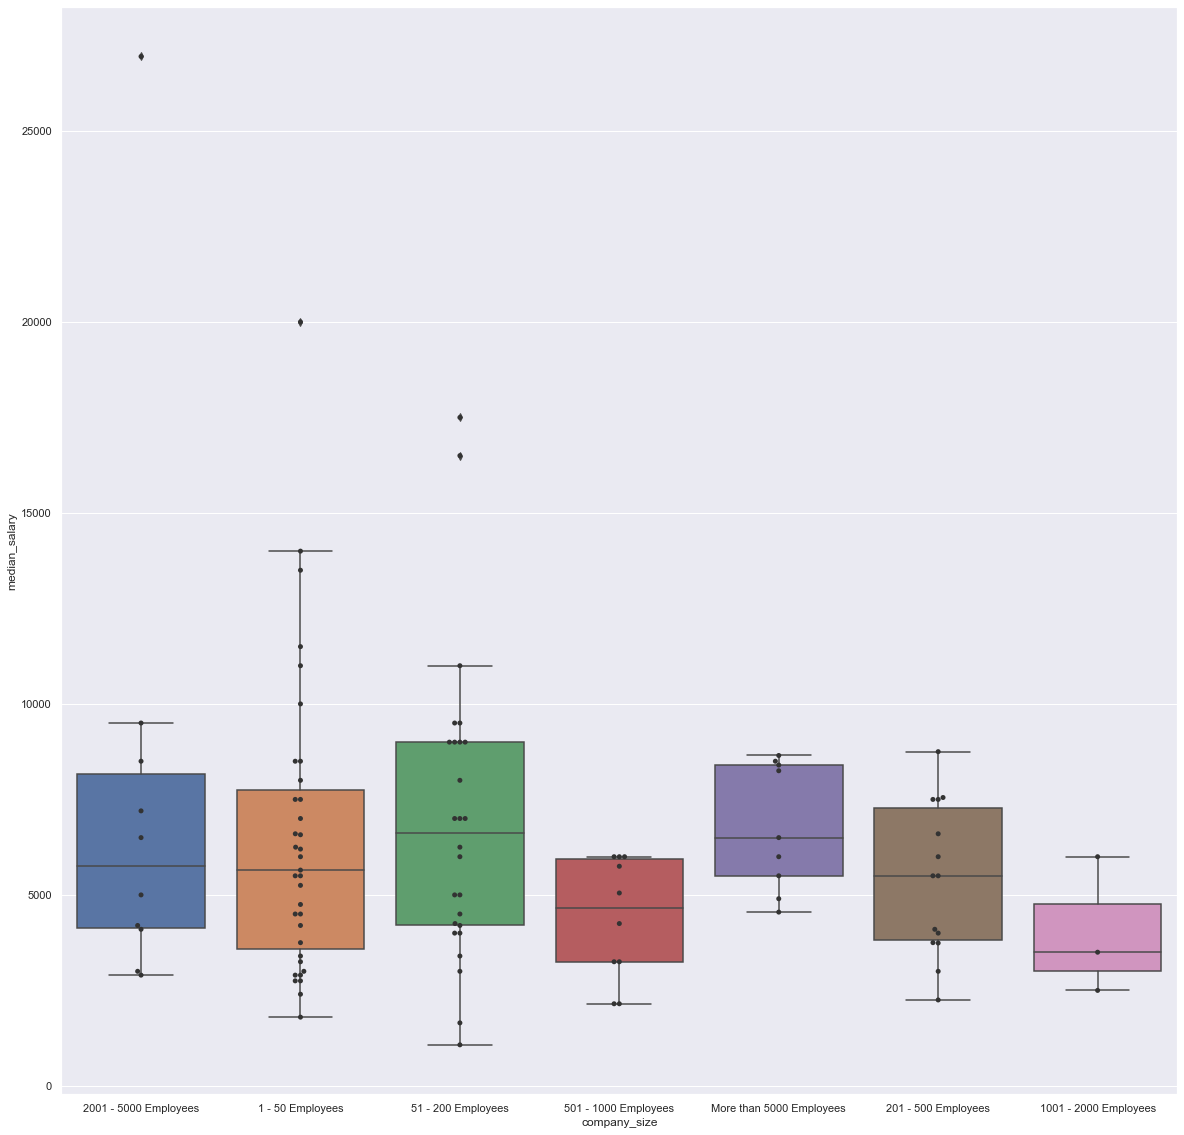

In [261]:
ax = sns.swarmplot(data=df_no_outliers, x="company_size", y="median_salary", color=".2")
ax = sns.boxplot(data=df_no_outliers, x="company_size", y="median_salary")
#ax.set_yticks(range(0,200000,4000))

In [262]:
df_no_outliers.groupby('company_size')['start_salary_range']

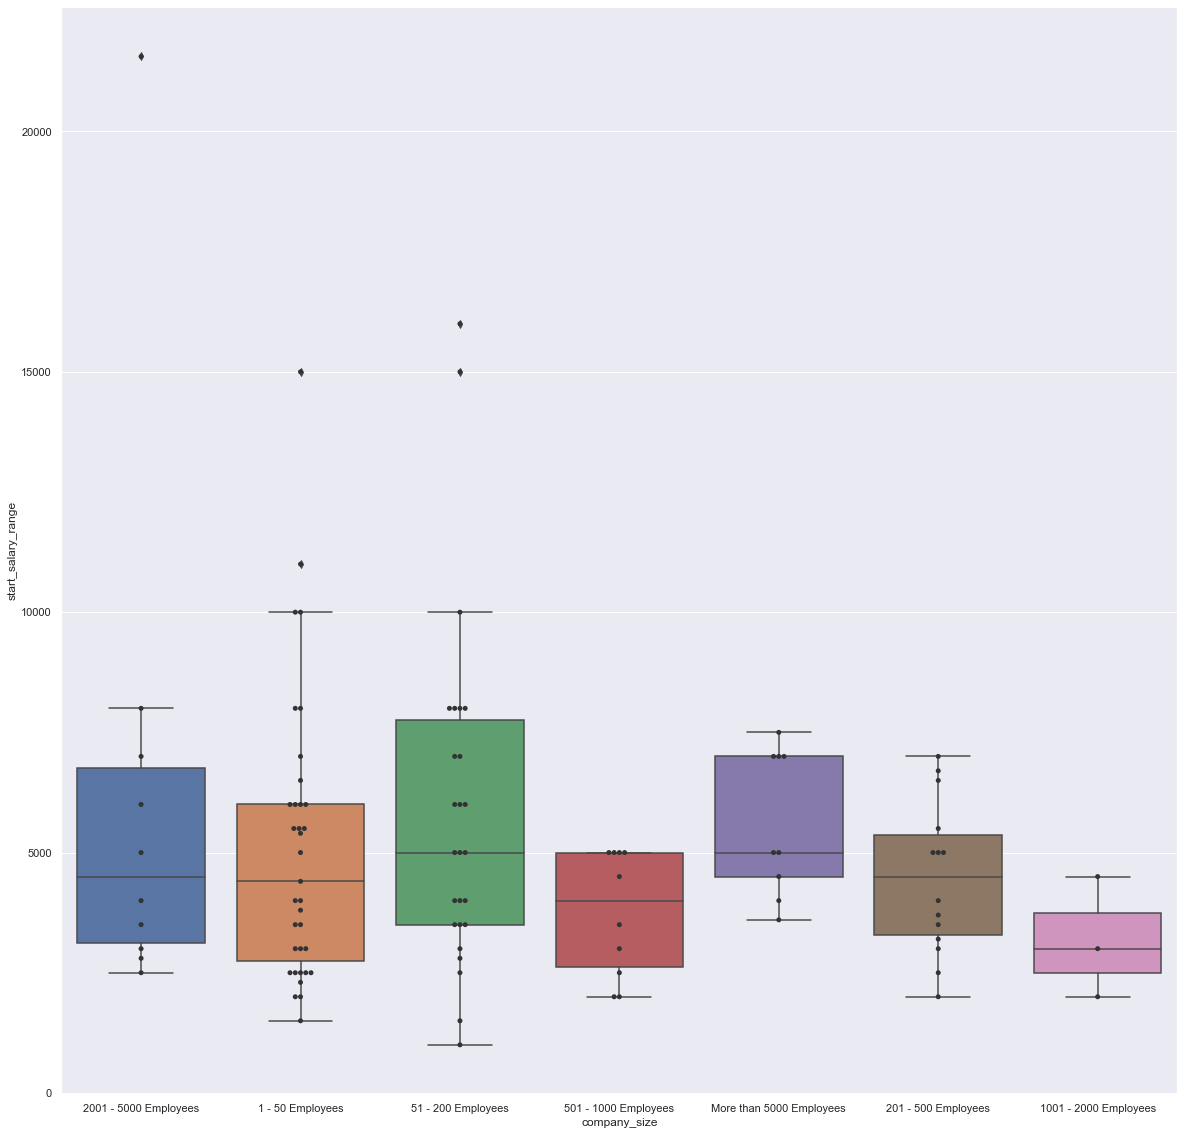

In [263]:
ax = sns.swarmplot(data=df_no_outliers, x="company_size", y="start_salary_range", color=".2")
ax = sns.boxplot(data=df_no_outliers, x="company_size", y="start_salary_range")

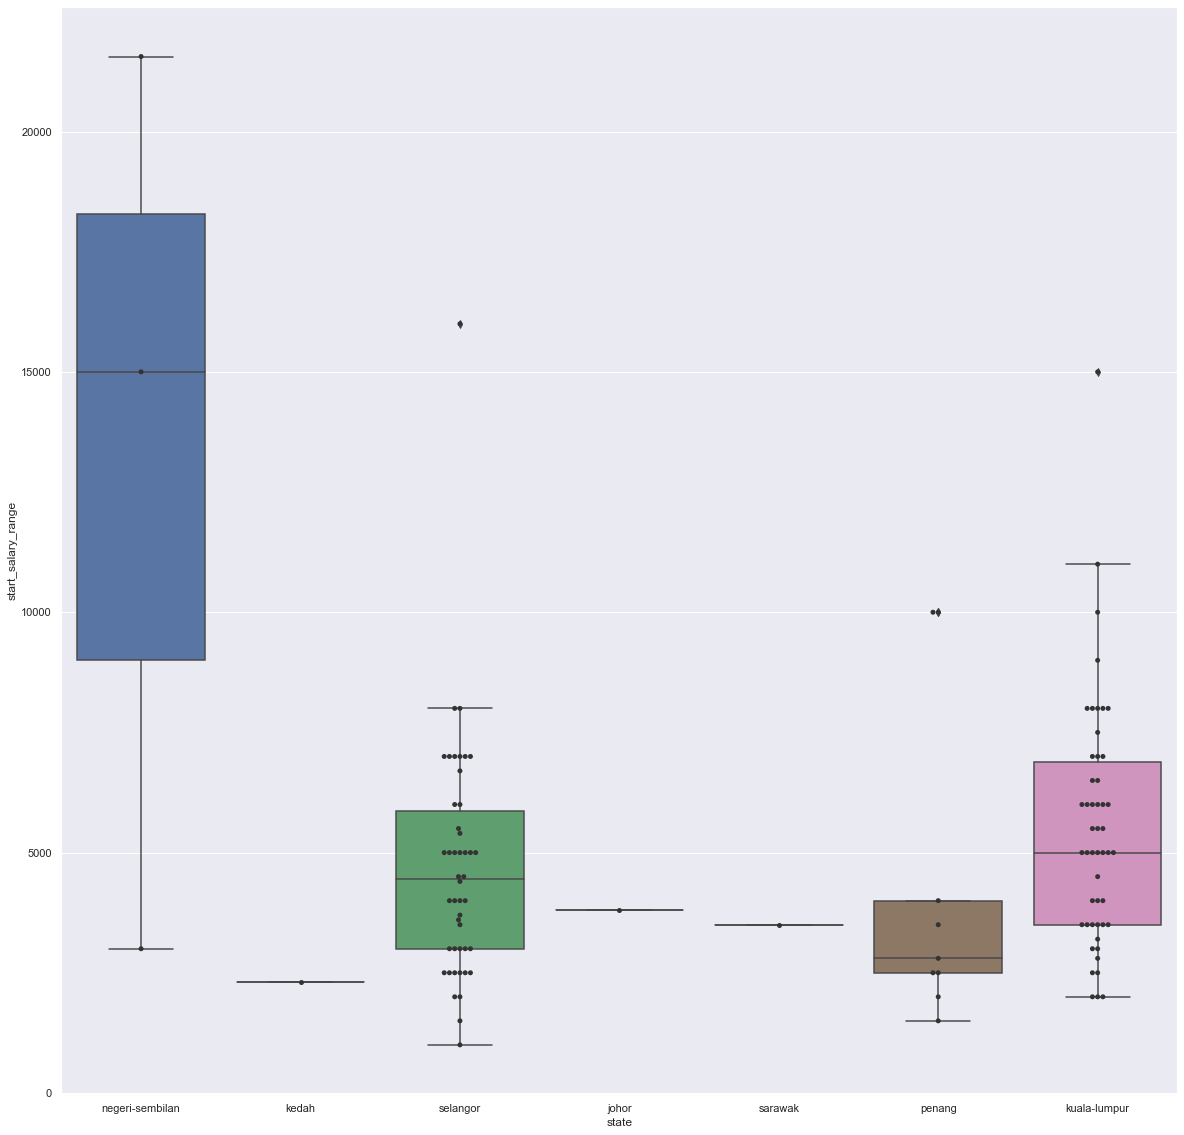

In [264]:
ax = sns.swarmplot(data=df_no_outliers, x="state", y="start_salary_range", color=".2")
ax = sns.boxplot(data=df_no_outliers, x="state", y="start_salary_range")

### Do smaller companies tend to hide their salaries?

In [265]:
df_no_salary = df_data_jobs
df_no_salary['no_salary'] = df_data_jobs['start_salary_range'].isna()
df_no_salary_count = df_no_salary.groupby('company_size')['no_salary'].sum()
df_company_size_jobs = df_data_jobs.groupby('company_size').size()
df_no_report_rate = df_no_salary_count/df_company_size_jobs

C:\Users\ryeoh\AppData\Local\Temp/ipykernel_10220/3791957627.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_salary['no_salary'] = df_data_jobs['start_salary_range'].isna()


In [266]:
df_no_report_rate=df_no_report_rate.loc[['1 - 50 Employees','51 - 200 Employees','201 - 500 Employees','501 - 1000 Employees','1001 - 2000 Employees','2001 - 5000 Employees','More than 5000 Employees']]

<AxesSubplot:xlabel='company_size'>

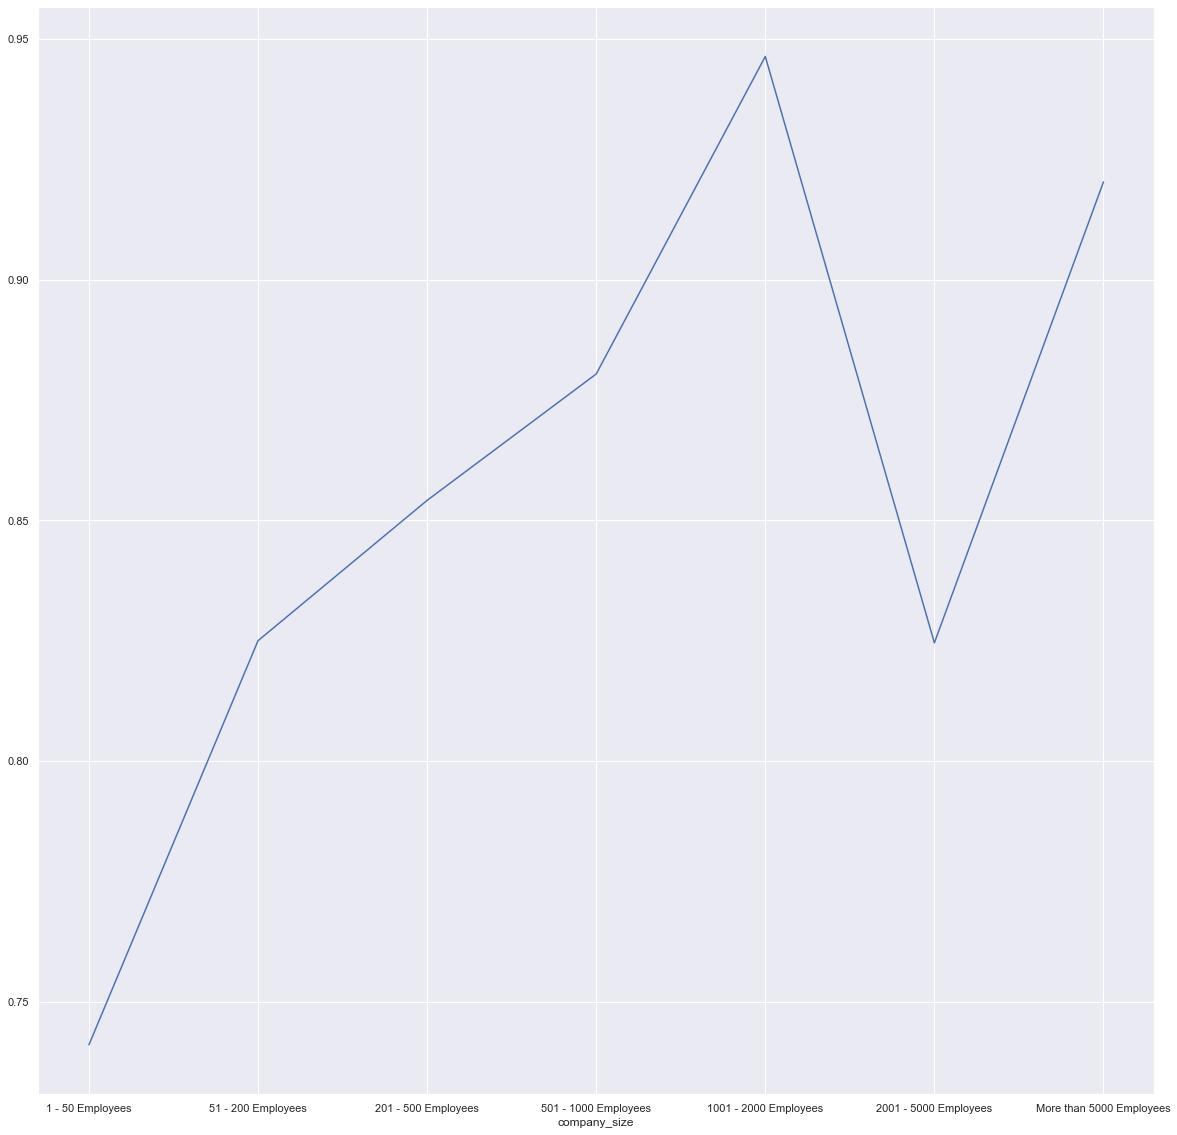

In [267]:
lnplot = sns.lineplot(x=df_no_report_rate.index, y=df_no_report_rate.values)
lnplot

### What is the job opportunity like for a fresh grad?

### Which state has the most opportunities for a freshie?

In [268]:
df_freshies = df_data_jobs[df_data_jobs['experience']<3|df_data_jobs['experience'].isna()]
len(df_freshies)

469

In [269]:
df_fresh_by_state = df_freshies.groupby('state').size()


In [270]:
df_fresh_by_state = df_fresh_by_state.sort_values()

[Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '5'),
 Text(0, 0, '8'),
 Text(0, 0, '12'),
 Text(0, 0, '38'),
 Text(0, 0, '153'),
 Text(0, 0, '241')]

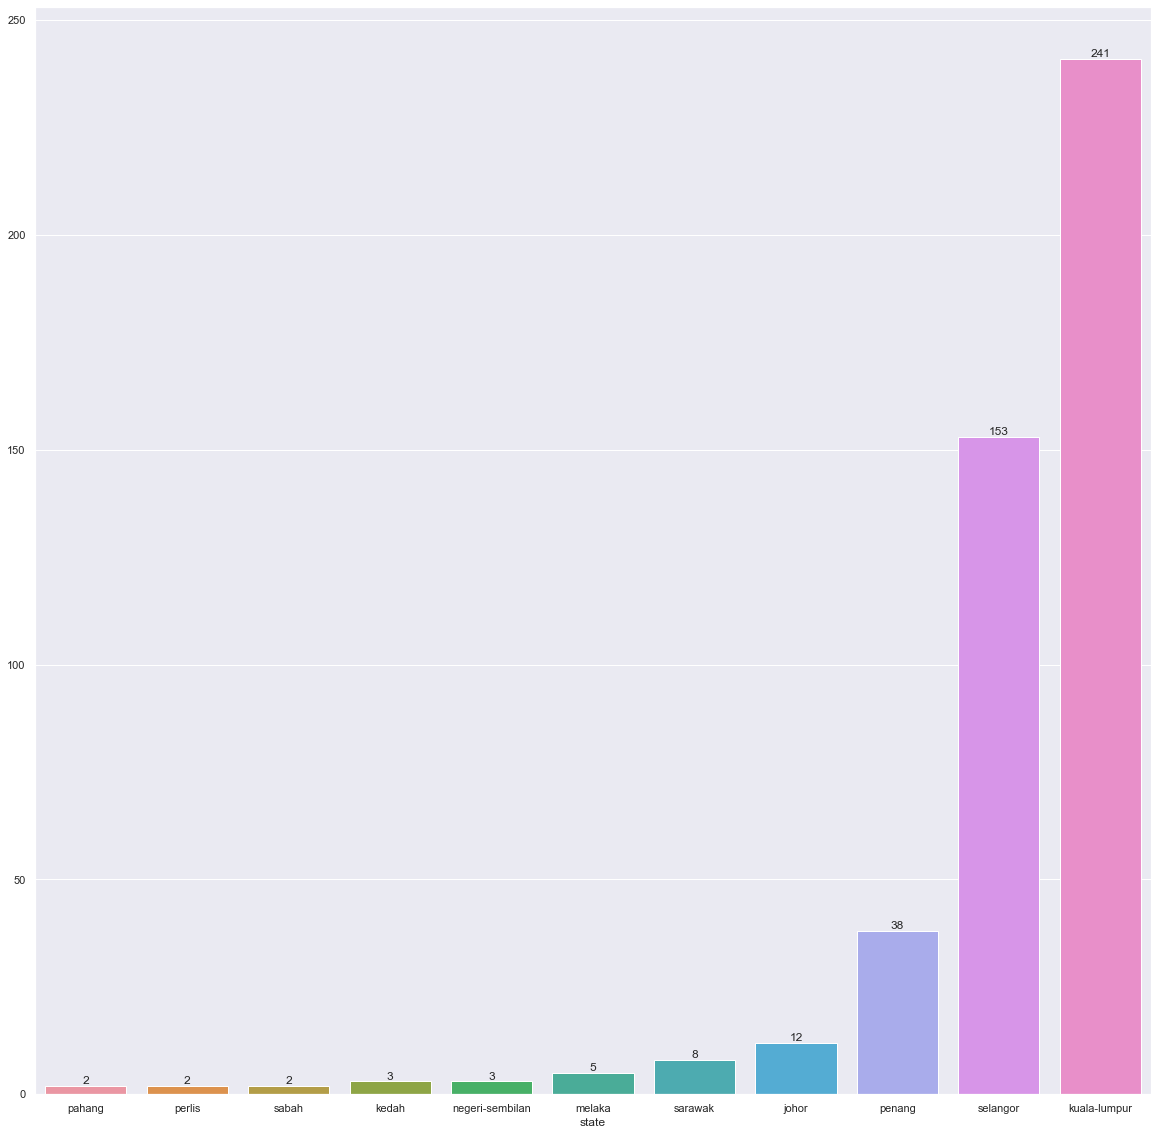

In [271]:
freshie_states = sns.barplot(x=df_fresh_by_state.index, y=df_fresh_by_state.values)
freshie_states.bar_label(freshie_states.containers[0])

### What is the starting salary like for a freshie?

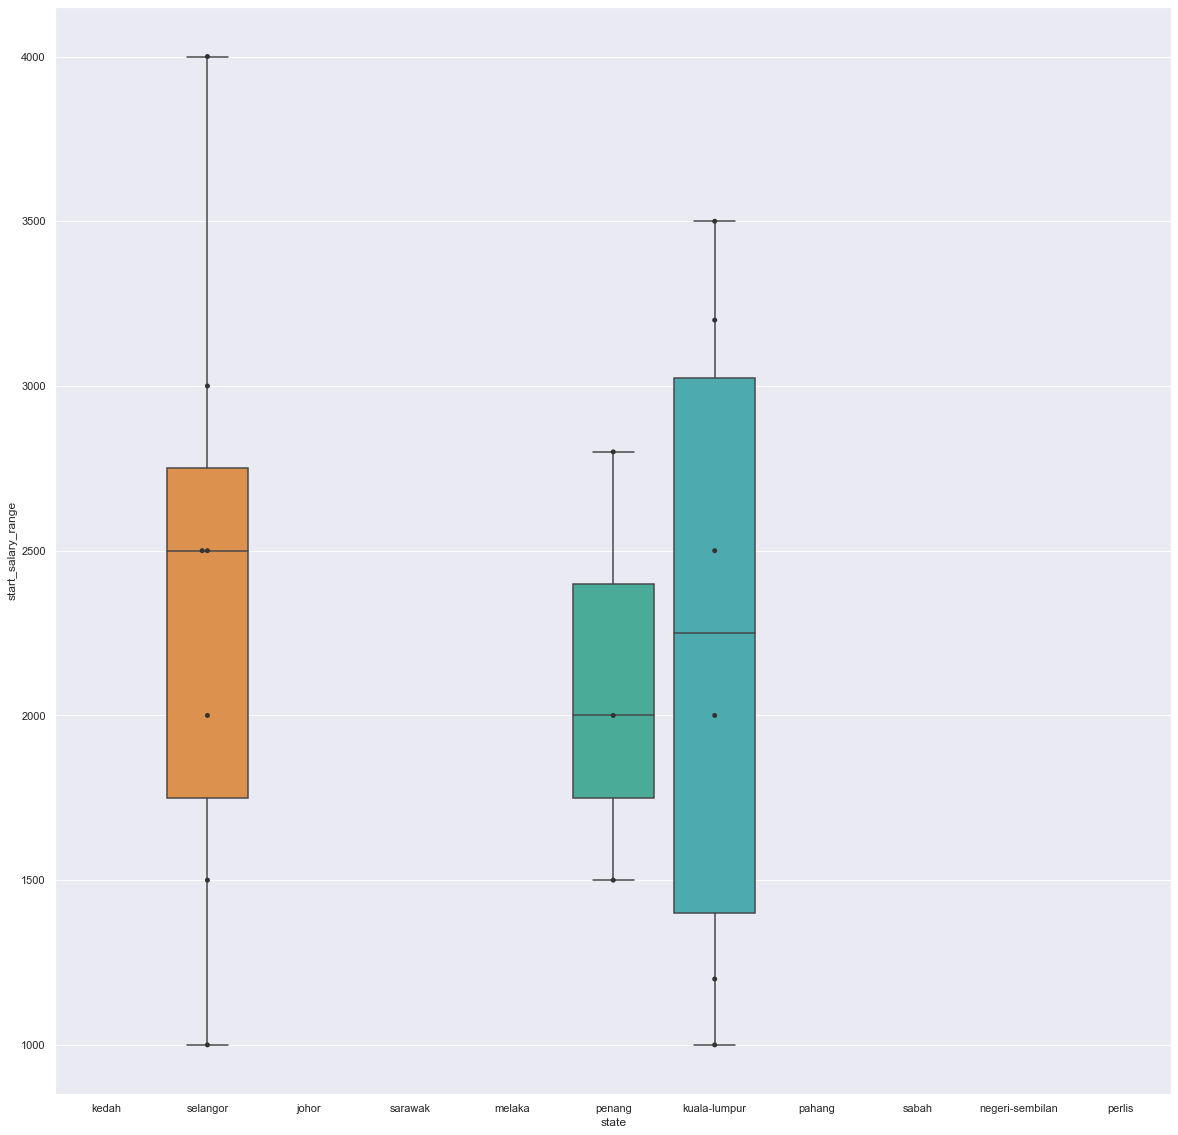

In [272]:
freshie_states = sns.boxplot(data=df_freshies, x='state', y='start_salary_range')
freshie_states = sns.swarmplot(data=df_freshies, x='state', y='start_salary_range', color='.2')


### Which career path is more lucrative?

In [273]:
df_data_scientist = df_data_jobs[df_data_jobs['job_title'].str.contains('data scientist')]
len(df_data_scientist)
df_data_scientist_with_salary = df_data_scientist[~df_data_scientist['start_salary_range'].isna()]
df_freshie_data_scientist_with_salary = df_data_scientist_with_salary[df_data_scientist_with_salary['experience']<3|df_data_scientist_with_salary['experience'].isna()]
df_freshie_data_scientist_with_salary['data_role'] = 'data scientist'
df_data_scientist_with_salary['data_role'] = 'data scientist'

C:\Users\ryeoh\AppData\Local\Temp/ipykernel_10220/3625479610.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_freshie_data_scientist_with_salary['data_role'] = 'data scientist'
C:\Users\ryeoh\AppData\Local\Temp/ipykernel_10220/3625479610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_scientist_with_salary['data_role'] = 'data scientist'


In [274]:
df_data_engineer = df_data_jobs[df_data_jobs['job_title'].str.contains('data engineer')]
len(df_data_engineer)
df_data_engineer_with_salary=df_data_engineer[~df_data_engineer['start_salary_range'].isna()]
print(len(df_data_engineer_with_salary))
df_freshie_data_engineer_with_salary = df_data_engineer_with_salary[df_data_engineer_with_salary['experience']<3|df_data_engineer_with_salary['experience'].isna()]
df_freshie_data_engineer_with_salary['data_role'] = 'data engineer'
df_data_engineer_with_salary['data_role'] = 'data engineer'

8


C:\Users\ryeoh\AppData\Local\Temp/ipykernel_10220/1812617773.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_engineer_with_salary['data_role'] = 'data engineer'


In [275]:
df_data_analyst = df_data_jobs[df_data_jobs['job_title'].str.contains('data analyst')]
len(df_data_analyst)
df_data_analyst_with_salary=df_data_analyst[~df_data_analyst['start_salary_range'].isna()]
df_freshie_data_analyst_with_salary = df_data_analyst_with_salary[df_data_analyst_with_salary['experience']<3|df_data_analyst_with_salary['experience'].isna()]
df_freshie_data_analyst_with_salary['data_role'] = 'data analyst'
df_data_analyst_with_salary['data_role'] = 'data analyst'

C:\Users\ryeoh\AppData\Local\Temp/ipykernel_10220/2965822623.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_freshie_data_analyst_with_salary['data_role'] = 'data analyst'
C:\Users\ryeoh\AppData\Local\Temp/ipykernel_10220/2965822623.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_analyst_with_salary['data_role'] = 'data analyst'


In [276]:
df_all_freshies = pd.concat([df_freshie_data_scientist_with_salary, df_freshie_data_engineer_with_salary, df_freshie_data_analyst_with_salary])


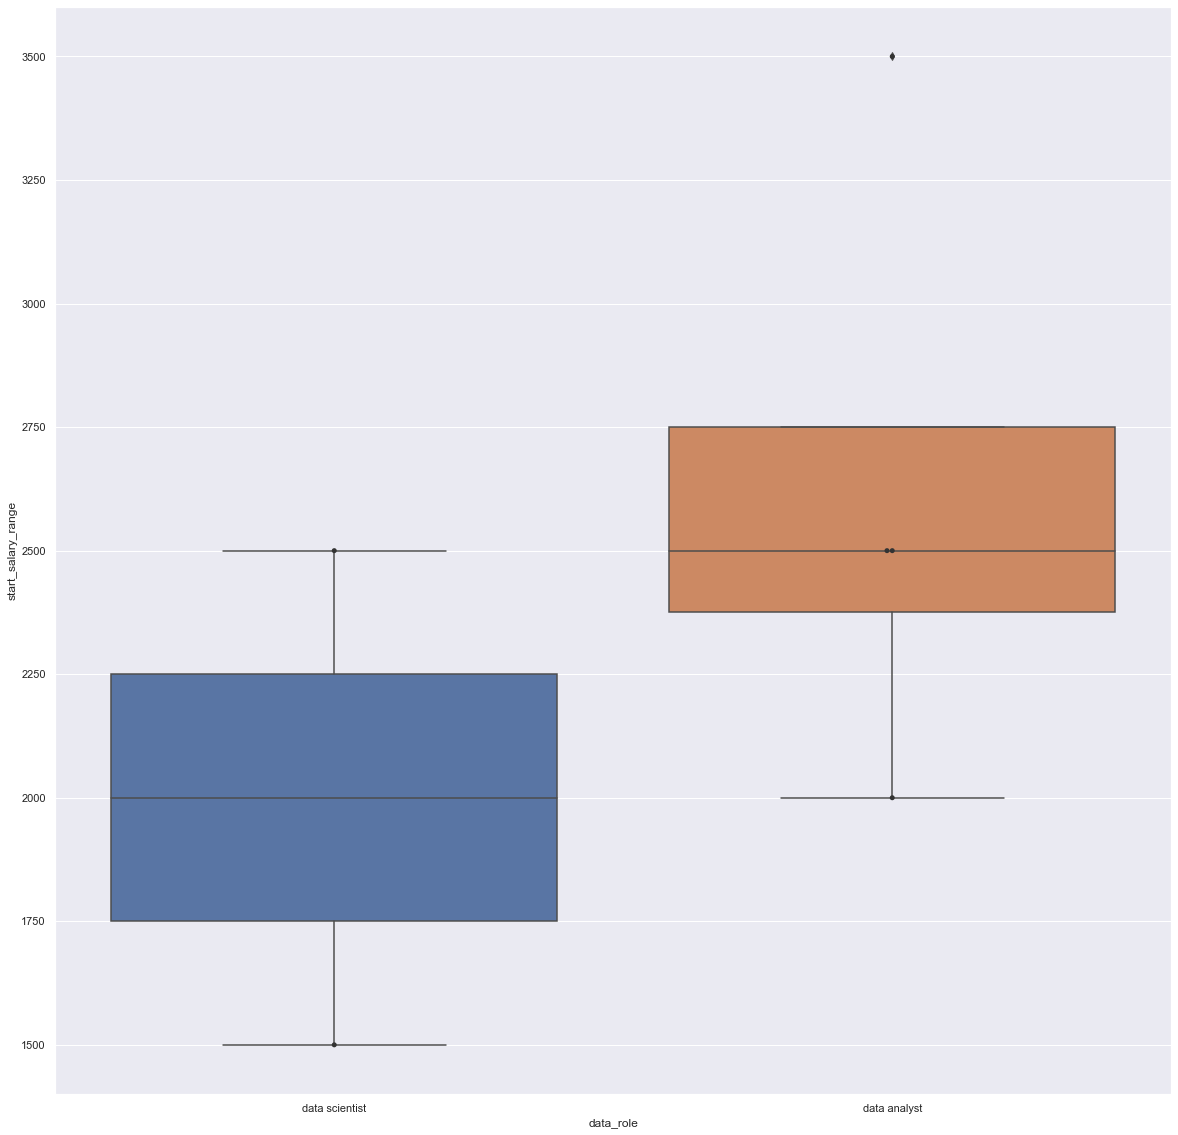

In [277]:
freshies = sns.swarmplot(data=df_all_freshies, x='data_role', y='start_salary_range',color='.2')
freshies = sns.boxplot(data=df_all_freshies, x='data_role', y='start_salary_range')

In [278]:
df_all_data_roles = pd.concat([df_data_scientist_with_salary, df_data_engineer_with_salary, df_data_analyst_with_salary])


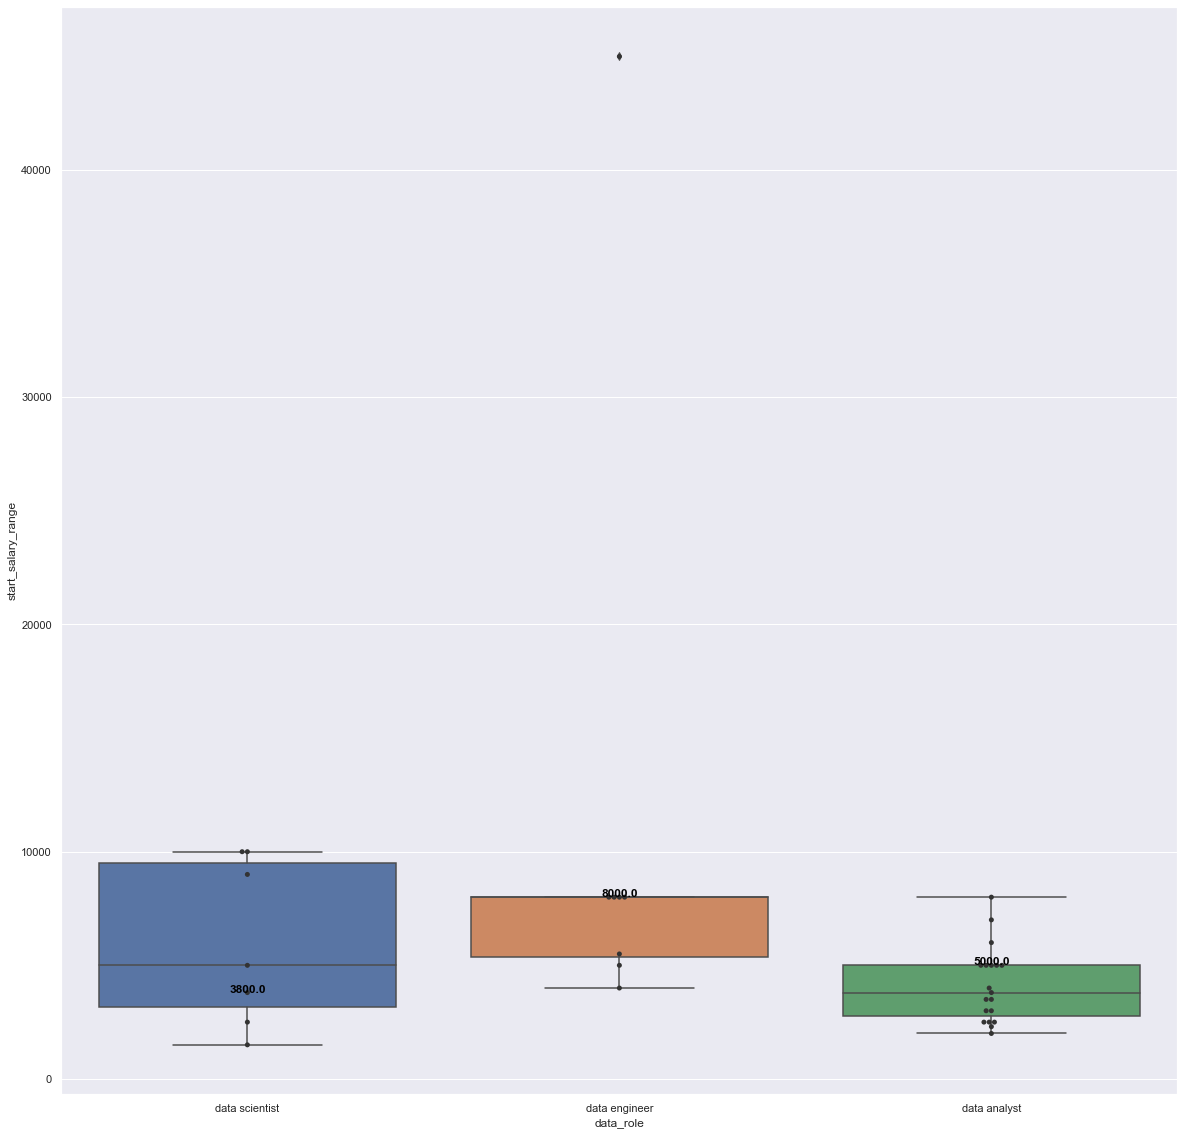

In [279]:
all_data = sns.swarmplot(data=df_all_data_roles, x='data_role', y='start_salary_range',color='.2')
all_data = sns.boxplot(data=df_all_data_roles, x='data_role', y='start_salary_range')

medians = df_all_data_roles.groupby('data_role')['start_salary_range'].median()
vertical_offset = df_all_data_roles['start_salary_range'].median() * 0.05

for xtick in all_data.get_xticks():
    all_data.text(xtick,medians[xtick], medians[xtick], horizontalalignment='center', color='black', weight='semibold')

In [280]:
df_data_jobs.iloc[0]['job_description'].lower().split('job description', 1)[1].split('additional information', 1)[0]

'remark :this position requires an employee to work physically in keysight singapore (yishun)keysight will handle employment pass application (to work in singapore); and bear all the cost involvedabout the job:the job is to design, define, maintain, and support the architecture of existing product. as an architect the person would be required to design and implement big data tools and frameworks, define elt processes, web services, collaborate with development teams, build platforms, and maintain the production system. you will also be the backend lead of a small dynamic team of software developers.you will work in an agile team to turn innovative ideas into robust software and solve complex design and implementation problems also to investigate new technologies and applications and apply modern software engineering practices such as unit testing and usability testing.about the team:we are part of the product development team that is responsible for the growth of the keysight businesse

In [281]:
df_data_jobs_clean_description = df_data_jobs
df_data_jobs_clean_description['clean_job_description'] = df_data_jobs['job_description'].str.lower()
df_data_jobs_clean_description['clean_job_description'] = df_data_jobs_clean_description['clean_job_description'].str.split('job description', 1).str[1].str.split('additional information', 1).str[0]

C:\Users\ryeoh\AppData\Local\Temp/ipykernel_10220/2305343014.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_jobs_clean_description['clean_job_description'] = df_data_jobs['job_description'].str.lower()
C:\Users\ryeoh\AppData\Local\Temp/ipykernel_10220/2305343014.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_jobs_clean_description['clean_job_description'] = df_data_jobs_clean_description['clean_job_description'].str.split('job description', 1).str[1].str.split('additional informati

In [282]:
df_data_jobs_clean_description.iloc[0].clean_job_description

'remark :this position requires an employee to work physically in keysight singapore (yishun)keysight will handle employment pass application (to work in singapore); and bear all the cost involvedabout the job:the job is to design, define, maintain, and support the architecture of existing product. as an architect the person would be required to design and implement big data tools and frameworks, define elt processes, web services, collaborate with development teams, build platforms, and maintain the production system. you will also be the backend lead of a small dynamic team of software developers.you will work in an agile team to turn innovative ideas into robust software and solve complex design and implementation problems also to investigate new technologies and applications and apply modern software engineering practices such as unit testing and usability testing.about the team:we are part of the product development team that is responsible for the growth of the keysight businesse

In [329]:
def cleanData(raw_text):    
    from nltk.corpus import stopwords
    from nltk.stem.porter import PorterStemmer
    from nltk.tokenize import RegexpTokenizer
    from nltk.stem.wordnet import WordNetLemmatizer

    # Custom Stopwords
    new_words = ["missing","abstract","we","in","the","using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown","skill",
    'business', 'experience', 'team', 'work', 'job',
    'amp', 'information', 'degree', 'management', 'development',
    'skill', 'support', 'project', 'solution', 'working',
    'process',
    'skill', 'informationcareer', 'knowledge',
    'customer', 'additional', 'year', 'timejob', 'typefull',
    'product', 'design', 'solution', 'technical', 'service', 'quality',
    'requirement', 'science',
    'year',
    'application', 'tool', 'professional', 'related',
    'specializationscomputer', 'diploma', 'good', 'graduate', 'ensure',
    'company', 'problem', 'strong', 'report', 'ability',
    'year', 'provide',
    'role', 'develop', 'requirement', 'tool', 'client',
    'performance', 'specifiedjob', 'user',
    'specifiedqualificationnot', 'levelnot', 'including','skill',
    'skill','solution', 'year',
    'requirement', 'tool', 'communication', 'environment', 'system',
    'reporting', 'across', 'platform', 'â', 'post', 'project', 'able',
    'service', 'process',
    'opportunity', 'model',
    'stakeholder', 'time', 'required','global', 'master', 'industry', 'insight', 'high', 'risk', 'level',
    'marketing', 'maintain', 'need', 'understanding', 'relevant', 'test',
    'within', 'end', 'bachelor', 'key', 'internal', 'issue', 'build',
    'best', 'least', 'responsible', 'well', 'people', 'based', 'etc',
    'digital',
    'help',
    'various', 'financial', 'yearsjob', 'improvement', 'operation', 'world',
    'testing', 'identify', 'candidate', 'degreeyears', 'source',
    'implementation', 'u', '3', 'functional', 'implement', 'part',
    'standard', 'g', 'activity', 'change', 'network', 'manage', 'must',
    'field', 'descriptionjob', 'make', 'perform', 'career', 'advanced', '2',
    'drive','e','group','solving','5','research','decision', 'excellent', 'lead',
       'like','group',
       'solving', '5', 'research','decision', 'excellent', 'lead',
       'like', 'looking', 'practice','market', 'written', 'area', 'create',
       'language', 'use', 'security', 'deliver', 'complex','apply','life', 'malaysia','understand',
       'day','improve', 'leading', 'office', 'finance','closely', '1', 'equivalent','compliance', 'added', 'services',
       'initiative', 'building', 'developing', 'position','english', 'banking', 'different',
       'requirements', 'review', 'existing', 'would','meet', 'highly', 'technique', 'take',
       'code', 'advantage', 'set', 'value', 'minimum', 'strategy','member',
       'executivequalificationbachelor', 'maintenance','documentation', 'operational','responsibility','communicate',
       'procedure','assist', 'managing', 'trend','integrity', 'levelsenior', 'organization',
       'providing', 'leave', 'responsibilities', 'capability','planning', 'employee', 'production', 'document','ms', '4','multiple', 'external','partner',
       'country','governance', 'cross',
       'expertise', 'relationship','monitor', 'conduct','great', 'growth', 'effective', 'requirementsjob','self', 'way', 'oriented', 'independently', 'senior', 'supporting',
       'impact', 'continuous', 'available', 'challenge', 'posse', 'timely',
       'department','preferably', 'innovative', 'ad', 'following',
       'making', 'current', 'detail', 'effectively','higher', 'approach', 'right', 'critical', 'case', 'ensuring','fast', 'efficiency', 'culture',
       'hoc', 'expert''verbal', 'consumer', 'assigned', 'accurate', 'strategic',
       'methodology', 'core', 'benifitsepfsocsoannual', 'prepare', 'place','resource', 'creating', 'description', 'future',
       'appropriate','status', 'verbal','community','leadership', 'dynamic', 'flexible', 'include',
       'familiar', 'collaborate', 'leveljunior', 'interpersonal', 'designing',
       'individual', 'innovation', 'unit', 'regulatory', 'resolve', 'focus','matter', 'necessary', 'site',
       'daily', 'participate', 'execute', 'hand', 'date', 'others',
       'successful', 'background', 'please', 'cost', 'online', 'preferred',
       'committed', 'enhance', 'better', 'asset', 'real', 'achieve', 'portfolio', 'success', 'together', 'may', 'analyse', 'purpose', 'delivering',
       'leader', 'regional', 'every', 'kuala','brand', 'insurance', 'benefit', 'solve',
       'get', 'duty','asia', 'method', 'contribute', 'experience3', 'specification', 'talent', 'exposure','grow', 'general', 'center','track', 'positive','implementing', 'medical', 'mission', 'bank', 'personal', 'enable', 'experience5', 'human', 'contact', 'according', 'proven',
       'includes','supply', 'coordinate', 'performing', 'handling', 'passion','education','technology', 'software','region', 'order', 'domain', 'finding', 'share', 'actionable', 'identifying', 'principle', 'metric', 'range', 'medium', 'international', 'qualification', 'chain', 'lumpur', 'employment',
       'define', 'interpret', 'attention', 'backup', 'assurance', 'workflow', 'object', 'per', 'material',
       'proactive', 'point', 'attitude', 'social', 'incident', 'scalable', 'helping', 'proactively', 'hr', 'recovery', 'specializationssales', 'transform', 'national', 'collection', 'commercial', 'play', 'guideline', 'basis', 'university', 'subject', 'present', 'top', 'wide', 'sales', 'assessment', 'check',
       'provides', 'around', 'location', 'experienced','execution', 'audit', 'scientist','scale', 'record', 'concept', 'proficiency', 'basic', 'update', 'operating',
       'migration', 'variety', 'campaign', 'skills', 'structure', 'owner', 'thinking', 'goal', 'systems', 'multi','discipline', 'seek', 'predictive', 'similar', 'line','entry', 'health', 'enhancement', 'class', 'via', 'collaboration', 'action',
       '8', 'specializationsaccounting', 'growing', 'follow', 'equal', 'efficient', 'proficient', 'motivated', 'organisation', 'automated', 'component', 'player', '7', 'consulting', 'troubleshooting',
       'monthly', 'specific', 'diverse','hands', 'writing', 'availability','diversity', 'colleague', 'needed', 'many','know','passionate', 'provided', 'salary', 'hour', 'root', 'clear', 'cause', '000', 'commerce', 'rule',
       'non', 'guidance', 'fresh', 'priority', 'extraction','inclusive', 'administrative', 'staff', 'emerging', 'outcome', 'overall', 'resources', 'creative', 'used', 'meeting',
       'pre', 'demand', 'changing', 'willing', 'creation', 'demonstrate', 'event', 'excellence', 'solutions', 'limited','payment', 'tracking', 'manner', 'experience2', 'deploy', 'mapping',
       'head', 'paced','person', 'largest', 'credit', 'journey','feedback', 'established', 'possible', 'lake', 'physical', 'typecontractjob','progress', 'establish', 'experience1', 'preparation', 'yearjob', 'revenue', 'account',
       'first', 'spoken', 'cycle', 'com', 'quickly', 'consultant', 'error', 'configuration', 'specialist', 'essential', 'malaysian','focused', 'form', 'always',
        'complete', 'deadline', 'optimize', 'relational', 'channel', 'shared', 'bhd', 'scope', 'retail', 'provider', 'live', 'unique', 'defined', 'base', 'public', 'embrace', 'month', 'organizational', 'logistics', 'come', 'file', 'singapore', 'find', 'input', 'website', 'possess', 'pricing', 'quantitative'
       'tools','projects', 'processes','stakeholders', 'technologies', 'insights', 'customers','products', 'us', 'issues','operations', 'clients','opportunities','applications', 'users', 'activities', 'problems', 'delivery',
'needs','standards', 'techniques','practices', 'integration','full','procedures','engineer', 'areas','sources','trends', 'tasks','members', 'sys', 'join','candidates','results', 'capabilities',
'learn', 'plan','transformation', 'companies', 'employees','potential','control','projects','processes','levelentry','levelqualificationbachelor','teams', 'specializationsadmin','clerical', 'executivequalificationnot', 'specifiedyears',
'ways', 'environments', 'structured', 'owners','goals', 'works','rules', 'accounting', 'associated', '10','pressure', 'translate', 'write', 'travel', 'solid', 'details', 'ongoing', 'sdn', 'setup', 'graduates', 'supervision', 'address', 'assets', 'centre',
'controls', 'supports', 'markets', 'days', 'generate', 'advice','findings', 'believe', 'small', 'energy', 'corporate', 'professionals', 'extensive', 'involved', 'descriptionthe',
'listed', 'bring', 'collaborative', 'influence', 'offers', 'values','principles', 'analysts','task', 'function', 'metrics','colleagues', 'developer', 'ideas','maintaining', 'plus', 'partners', 'policies', 'challenges',
'countries', 'plans', 'sets','offer', 'coding', '6', 'open', 'framework', 'presentation', 'risks','documents','roles', 'media','guidelines', 'fields',
 'start', 'specializationssciences', 'automate', 'regular', 'load', 'annual', 'forward', 'capacity', 'familiarity', 'applying', 'takes', 'logical', 'terms', 'ownership', 'run', 'click', 'departments', 'care', 
 'levelmanagerqualificationbachelor', 'gender', 'seeking', 'communities', 'recommend', 'structures', 'stack', 'today', 'designs', 'deliverables', 'email', 'industries', 'back', 'comprehensive', 'tests', 'guide', 'assess', 'depth',
 'shortlisted', 'ready','executivequalificationdiploma', 'usage', 'effectiveness', 'search', 'especially', 'mindset', 'long', 'analyzing', 'sense', 'applied', 'junior','primary', 'encouraged', 'continuously',
 'sexual', 'orientation','demonstrated', 'currently', 'evaluate', 'employer', 'fully', 'engagement', 'defining', 'home', 'content', 'serve', 'validate', 'consistent','facilitate', 'handle', 'teaching', 'interested', 'reviews', 'resolution', 'fraud'
 ,'9', 'outcomes', 'act', 'involve', 'towards', 'minimal', 'www', 'matters', 'without', 'direction', 'important', 'prioritize', 'degreejob', 'productivity','recruitment', 'gathering', 'gather', 'units', 'improving', 'proud', 'jobs', 'datasets', 'economics', 'aspects', 'legacy', 'communications',
 'term', 'independent', 'brands', 'accordance', 'oral', 'actively']
    stop_words = set(stopwords.words('english'))
    stop_words = stop_words.union(set(new_words))
    tokenizer = nltk.RegexpTokenizer(r"\w+", )
    words = tokenizer.tokenize(raw_text)

    # lem = WordNetLemmatizer()
    # wordsLemmatized=[]
    # #Lemmatisation
    # for word in words:
    #     wordsLemmatized.append(lem.lemmatize(word))

    wordsFiltered=[]
    for word in words:
        if word.lower() not in stop_words:
            wordsFiltered.append(word)
    
    
    
#   Convert to lowercase
    str=''
    for w in wordsFiltered:
        str = str+' '+w.lower()
    return str

In [330]:
stop = stopwords.words('english')

job_description_no_stopwords = df_data_jobs_clean_description['job_description'].apply(cleanData)

In [331]:
df_data_jobs_clean_description['job_requirement'] = job_description_no_stopwords

C:\Users\ryeoh\AppData\Local\Temp/ipykernel_10220/1700067108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_jobs_clean_description['job_requirement'] = job_description_no_stopwords


In [332]:
freq = pd.Series(''.join(df_data_jobs_clean_description['job_requirement']).split()).value_counts()[:200]
print(list(freq.index))

['data', 'analytics', 'analysis', 'database', 'years', 'sql', 'tools', 'computer', 'engineering', 'analytical', 'reports', 'learning', 'bi', 'cloud', 'models', 'python', 'power', 'programming', 'big', 'intelligence', 'sap', 'etl', 'machine', 'microsoft', 'training', 'databases', 'architecture', 'infrastructure', 'statistics', 'monitoring', 'oracle', 'admin', 'excel', 'db', 'automation', 'analyst', 'web', 'azure', 'processing', 'driven', 'platforms', 'tableau', 'r', 'visualization', 'analyze', 'agile', 'server', 'statistical', 'warehouse', 'enterprise', 'dashboards', 'ai', 'aws', 'deep', 'modelling', 'manager', 'manufacturing', 'administration', 'accuracy', 'access', 'languages', 'changes', 'improvements', 'pipelines', 'initiatives', 'levels', 'duties', 'engineers', 'decisions', 'c', 'strategies', 'benefits', 'deployment', 'java', 'hadoop', 'google', 'algorithms', 'mathematics', 'spark', 'sas', 'requests', 'relationships', 'expert', 'storage', 'actuarial', 'objectives', 'cases', 'functi

In [333]:
freq

data               5521
analytics           744
analysis            616
database            562
years               561
sql                 543
tools               495
computer            441
engineering         430
analytical          358
reports             346
learning            343
bi                  342
cloud               269
models              237
python              231
power               227
programming         227
big                 225
intelligence        222
sap                 209
etl                 202
machine             199
microsoft           196
training            196
databases           193
architecture        186
infrastructure      186
statistics          183
monitoring          165
oracle              163
admin               160
excel               159
db                  158
automation          158
analyst             155
web                 154
azure               154
processing          153
driven              152
platforms           146
tableau         

In [326]:
def get_top_n_words(corpus,n=None,ngram=1):
    vec = CountVectorizer(ngram_range=(ngram,ngram)).fit(corpus) # generate a dictionary from abstract
    bag_of_words = vec.transform(corpus)
    #bag_of_words = CountVectorizer().fit_transform(corpus) # create a matrix based on the dictionary

    # vocab = vec.vocabulary_
    # count_values = bag_of_words.toarray().sum(axis=0)

    # for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()][:20], reverse=True):
    #     print(ng_count, ng_text)

    sum_words = bag_of_words.sum(axis=0) # sum the occurrence  
    word_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()] # generate the word with occurrence
    words_freq = sorted(word_freq, key=lambda x:x[1],reverse=True) # sort from highest count to lowest
    return words_freq[:n] # return n top words
    return vec, sum_words

In [334]:
n_count_1 = get_top_n_words(df_data_jobs_clean_description['job_requirement'].tolist(), 50)
n_coun_2 = get_top_n_words(df_data_jobs_clean_description['job_requirement'].tolist(), 50,2)

In [305]:
pd.DataFrame(n_count_1)

,0,1
0,data,5521
1,analytics,744
2,analysis,616
3,database,562
4,years,561
5,sql,543
6,tools,495
7,computer,441
8,engineering,430
9,analytical,358


In [306]:
ngram_1_dict = {key:value for key,value in n_count_1}

In [292]:
wc = WordCloud(width=800,height=400,colormap='Greys', background_color='#ffb703').generate_from_frequencies(ngram_1_dict)

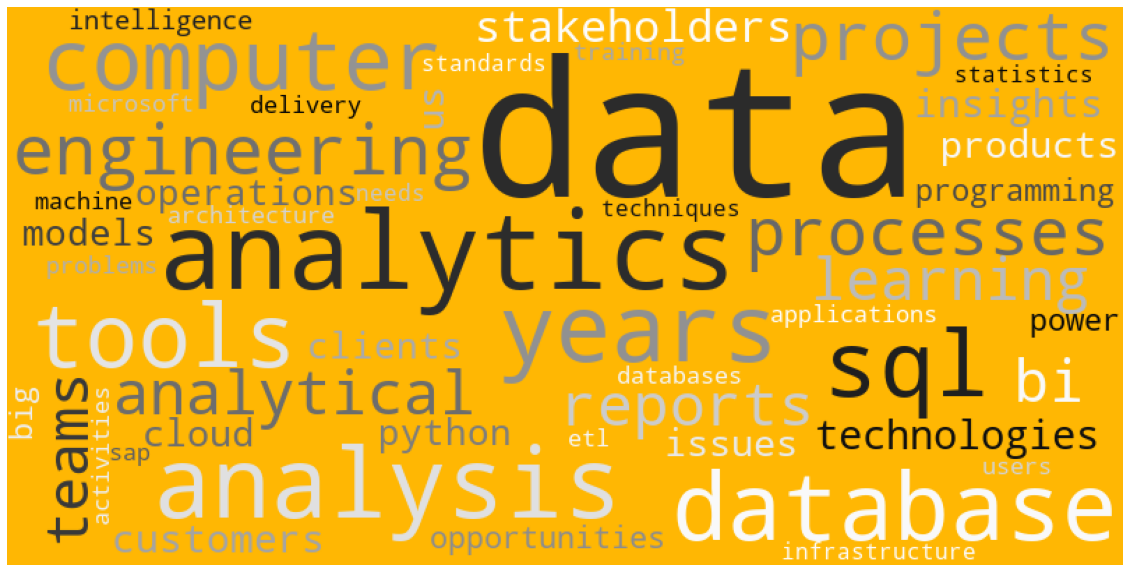

In [293]:
plt.imshow(wc)
plt.axis('off')
plt.show()

In [335]:
pd.DataFrame(n_coun_2)

,0,1
0,data data,480
1,data analytics,261
2,machine learning,185
3,big data,183
4,data analysis,174
5,power bi,138
6,db admin,133
7,years data,108
8,data warehouse,106
9,data visualization,90


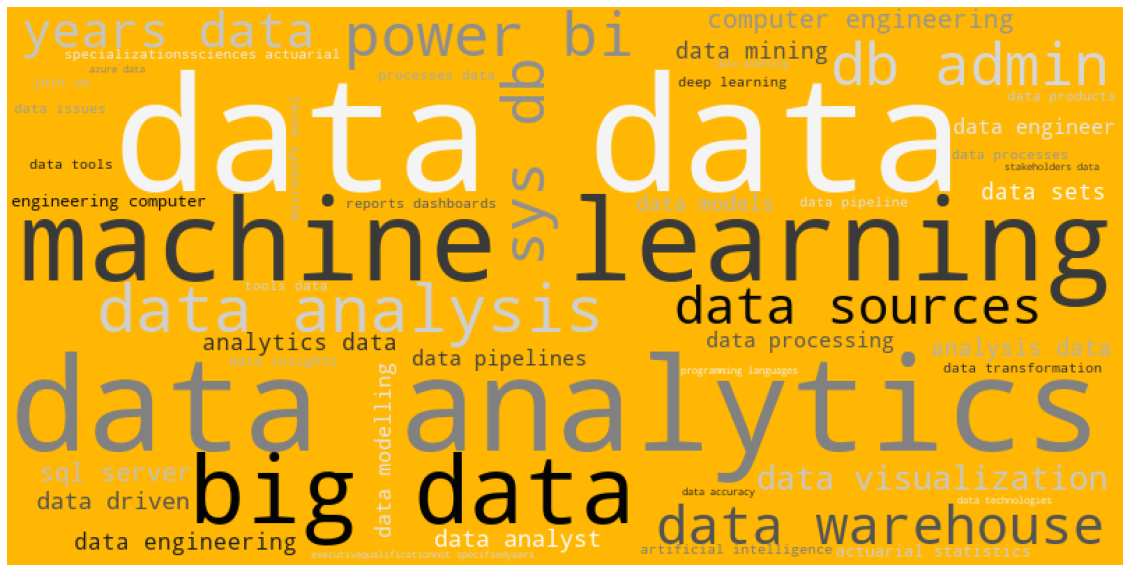

In [295]:

ngram_2_dict = {key:value for key,value in n_coun_2}
wc2 = WordCloud(width=800,height=400,colormap='Greys', background_color='#ffb703').generate_from_frequencies(ngram_2_dict)
plt.imshow(wc2)
plt.axis('off')
plt.show()

### Create feature extraction for job description

In [343]:
vec_count1 = CountVectorizer(ngram_range=(1,1), max_features=50).fit(df_data_jobs_clean_description['job_requirement'].tolist()) # generate a dictionary from abstract
bag_of_words_count1 = vec_count1.transform(df_data_jobs_clean_description['job_requirement'].tolist())
#bag_of_words = CountVectorizer().fit_transform(corpus) # create a matrix based on the dictionary

# vocab = vec.vocabulary_
# count_values = bag_of_words.toarray().sum(axis=0)

# for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()][:20], reverse=True):
#     print(ng_count, ng_text)

sum_words_count1 = bag_of_words_count1.sum(axis=0) # sum the occurrence
word_freq_count1 = [(word, sum_words_count1[0,idx]) for word, idx in vec_count1.vocabulary_.items()] # generate the word with occurrence
words_freq_count1 = sorted(word_freq_count1, key=lambda x:x[1],reverse=True) # sort from highest count to lowest


vec_count2 = CountVectorizer(ngram_range=(2,2), max_features=50).fit(df_data_jobs_clean_description['job_requirement'].tolist())
bag_of_words_count2 = vec_count2.transform(df_data_jobs_clean_description['job_requirement'].tolist())
#bag_of_words = CountVectorizer().fit_transform(corpus) # create a matrix based on the dictionary

# vocab = vec.vocabulary_
# count_values = bag_of_words.toarray().sum(axis=0)

# for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()][:20], reverse=True):
#     print(ng_count, ng_text)

sum_words_count2 = bag_of_words_count2.sum(axis=0) # sum the occurrence
word_freq_count2 = [(word, sum_words_count2[0,idx]) for word, idx in vec_count2.vocabulary_.items()] # generate the word with occurrence
words_freq_count2 = sorted(word_freq_count2, key=lambda x:x[1],reverse=True) # sort from highest count to lowest



In [344]:
selected_features_count1 = [feature_pair[0] for feature_pair in words_freq_count1[:50]]
selected_features_count2 = [feature_pair[0] for feature_pair in words_freq_count2[:50]]

In [355]:
df_count1 = pd.DataFrame(bag_of_words_count1.A, columns=vec_count1.get_feature_names())
df_count2 = pd.DataFrame(bag_of_words_count2.A, columns=vec_count2.get_feature_names())

C:\Users\ryeoh\Anaconda3\envs\forwardSchool\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [358]:
df_description_tokenized = pd.concat([df_count1,df_count2], axis=1)

In [359]:
df_description_tokenized.head()

,admin,agile,analysis,analyst,analytical,analytics,analyze,architecture,automation,azure,bi,big,cloud,computer,dashboards,data,database,databases,db,driven,engineering,enterprise,etl,excel,infrastructure,intelligence,learning,machine,microsoft,models,monitoring,oracle,platforms,power,processing,programming,python,reports,sap,server,sql,statistical,statistics,tableau,tools,training,visualization,warehouse,web,years,actuarial statistics,analysis data,analyst data,analytics data,analyze data,artificial intelligence,azure data,big data,ci cd,computer data,computer engineering,data accuracy,data analysis,data analyst,data analytics,data architecture,data data,data driven,data engineering,data infrastructure,data mining,data modeling,data modelling,data models,data pipeline,data pipelines,data processing,data reports,data scientists,data tools,data visualization,data warehouse,data warehousing,database data,database database,db admin,deep learning,engineering computer,etl data,machine learning,microsoft excel,power bi,programming languages,reports dashboards,reports data,sql queries,sql server,tools data,visualization tools,years data
0,0,3,0,0,0,0,0,3,0,0,0,4,2,2,0,7,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,0,0,0,4,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,2,0,1,0,9,14,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,2,0,0,1,0,2,0,0,0,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,2,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,0,1,0,0,0,1,1,0,0,0,0,0,2,0,2,2,4,1,0,3,1,0,0,1,0,0,0,0,0,2,4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Get dataframe ready for training

In [363]:
df_training = df_data_jobs_clean_description.reset_index(drop=True)
df_training.drop(['job_id', 'job_title', 'job_description', 'job_specialization', 'company_name','company_registration', 'job_link', 'search_term', 'clean_job_description', 'job_requirement'], inplace=True, axis=1)

In [364]:
df_training.head()

,job_level,experience,job_type,qualifications,company_size,company_industry,state,start_salary_range,end_salary_range,median_salary,no_salary
0,Manager,7,Full-Time,"Bachelor's Degree, Post Graduate Diploma, Prof...",2001 - 5000 Employees,Electrical & Electronics,negeri-sembilan,21560.0,32340.0,26950.0,False
1,Senior Executive,3,Full-Time,"Bachelor's Degree, Post Graduate Diploma, Prof...",1 - 50 Employees,Computer / Information Technology (Software),negeri-sembilan,15000.0,25000.0,20000.0,False
2,Junior Executive,2,Full-Time,"Bachelor's Degree, Post Graduate Diploma, Prof...",1 - 50 Employees,General & Wholesale Trading,kedah,2300.0,3500.0,2900.0,False
3,Not Specified,0,None,Not Specified,More than 5000 Employees,Semiconductor/Wafer Fabrication,kedah,NaN,NaN,NaN,True
4,Senior Executive,2,Full-Time,Not Specified,More than 5000 Employees,Hotel / Hospitality,pahang,NaN,NaN,NaN,True


##### Encode job_level

In [383]:
categories={'Not Specified':0,'Non-Executive':1,'Entry Level':2,'Junior Executive':3,'Senior Executive':4,'Manager':5, 'Senior Manager':6}
df_training['job_level'] = df_training['job_level'].map(categories)

##### Encode job_type

In [386]:
job_types = ['Contract', 'Full-Time', 'Full-Time, Internship', 'Internship' ,'Part-Time', 'Temporary']
df_job_type = pd.get_dummies(df_training['job_type'])
df_training_en = df_training.join(df_job_type).drop('job_type',axis=1)


##### Encode company size


In [393]:
company_sizes = {'1 - 50 Employees':0,'51 - 200 Employees':1,'201 - 500 Employees':2, '501 - 1000 Employees':3,'1001 - 2000 Employees':4,'2001 - 5000 Employees':5, 'More than 5000 Employees':6 }
df_training_en['company_size'] = df_training_en['company_size'].map(company_sizes)

In [394]:
df_training_en

,job_level,experience,qualifications,company_size,company_industry,state,start_salary_range,end_salary_range,median_salary,no_salary,Contract,Full-Time,"Full-Time, Internship",Internship,Part-Time,Temporary
0,5,7,"Bachelor's Degree, Post Graduate Diploma, Prof...",5.0,Electrical & Electronics,negeri-sembilan,21560.0,32340.0,26950.0,False,0,1,0,0,0,0
1,4,3,"Bachelor's Degree, Post Graduate Diploma, Prof...",0.0,Computer / Information Technology (Software),negeri-sembilan,15000.0,25000.0,20000.0,False,0,1,0,0,0,0
2,3,2,"Bachelor's Degree, Post Graduate Diploma, Prof...",0.0,General & Wholesale Trading,kedah,2300.0,3500.0,2900.0,False,0,1,0,0,0,0
3,0,0,Not Specified,6.0,Semiconductor/Wafer Fabrication,kedah,NaN,NaN,NaN,True,0,0,0,0,0,0
4,4,2,Not Specified,6.0,Hotel / Hospitality,pahang,NaN,NaN,NaN,True,0,1,0,0,0,0
